In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from scipy.sparse import hstack

In [10]:
import warnings
warnings.filterwarnings("ignore")

In [11]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [12]:
from nltk.corpus import stopwords
import re
import time
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.metrics.classification import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression

In [14]:
!wget --header="Host: storage.googleapis.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/86.0.4240.75 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-GB,en-US;q=0.9,en;q=0.8" --header="Referer: https://www.kaggle.com/" "https://storage.googleapis.com/kagglesdsdata/competitions/6841/44307/training_variants.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1603604485&Signature=YMP0qYsHiuI480KdLIEyXzu5bHTC4aI497T50Piu88B8Uuc4wzuxUt17jEd2OtoOQGhTFKVMT4DoAxe6OEnB%2B1jv1uJvo37ivjsfjXE5j1d77wWZZsO8Ouh5ytOvgAoSr5bTnBdJRkE4npR82eHCL9vbtnWb3ubno5DmAd4%2FJiSaqZWJi2LJZrCFXQLP%2Bs5o6eFmP0s0zjhq6Jg%2Bk%2BK6tQCx3Of0MIjJVhKODJfmA%2FLBKD69sMuCiAuX9LWW%2BgDRW3AFCJFmbArkpL%2BtzAs1ksvLrwYfe9z9pQWtJUSQ%2Fo3sQEyXXJnnoPloY43X3ewSKmBNLyyxN27XjPq9yj6pNg%3D%3D&response-content-disposition=attachment%3B+filename%3Dtraining_variants.zip" -c -O 'training_variants.zip'

--2020-10-22 05:42:08--  https://storage.googleapis.com/kagglesdsdata/competitions/6841/44307/training_variants.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1603604485&Signature=YMP0qYsHiuI480KdLIEyXzu5bHTC4aI497T50Piu88B8Uuc4wzuxUt17jEd2OtoOQGhTFKVMT4DoAxe6OEnB%2B1jv1uJvo37ivjsfjXE5j1d77wWZZsO8Ouh5ytOvgAoSr5bTnBdJRkE4npR82eHCL9vbtnWb3ubno5DmAd4%2FJiSaqZWJi2LJZrCFXQLP%2Bs5o6eFmP0s0zjhq6Jg%2Bk%2BK6tQCx3Of0MIjJVhKODJfmA%2FLBKD69sMuCiAuX9LWW%2BgDRW3AFCJFmbArkpL%2BtzAs1ksvLrwYfe9z9pQWtJUSQ%2Fo3sQEyXXJnnoPloY43X3ewSKmBNLyyxN27XjPq9yj6pNg%3D%3D&response-content-disposition=attachment%3B+filename%3Dtraining_variants.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.189.128, 108.177.97.128, 74.125.203.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.189.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24831 (24K) [application/zip]
Saving to: ‘training_variants.zip’

training_variants.z 

In [15]:
!unzip training_variants.zip -d training_variants

Archive:  training_variants.zip
  inflating: training_variants/training_variants  


In [16]:
file1=pd.read_csv('training_variants/training_variants')

In [17]:
print('Number of data points : ', file1.shape[0])
print('Number of features : ', file1.shape[1])
print('Features : ', file1.columns.values)
file1.head()

Number of data points :  3321
Number of features :  4
Features :  ['ID' 'Gene' 'Variation' 'Class']


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


## Reading the text data

In [18]:
!wget --header="Host: storage.googleapis.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/86.0.4240.75 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-GB,en-US;q=0.9,en;q=0.8" --header="Referer: https://www.kaggle.com/" "https://storage.googleapis.com/kagglesdsdata/competitions/6841/44307/training_text.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1603604426&Signature=Cjcx%2F6jcWvjP9DxA3lhNhEcVXSadjyoMBHf4jwRv5XAe2XOmDXYGQLI79UANE%2BWkyszpkEi8fJvwJR0ru3QNx0FKrtSrKTowlJ5GB%2BjYJPpmeh8HtZzo0OxVZN6ugH3U6xsoX0V6Ppe3j%2Fq77DkZyUDrTQn4XGzSgD3RDRNnJY7JYylkgoSbXXfAImiBFENWXk6o4SmXweMIYO%2Fia8xGIVju%2BDbe36yYL%2Bd89K8Ib2fFVn%2BuqXuOzKwDqUBNU4UJDSBe1SjFusVEU7lA8EdzJsoRaNnInFd8UIq%2FqVachSmijayqsV4cZBu23izW4MVRLum9j%2Bje%2BReXsv7BCQCT%2FQ%3D%3D&response-content-disposition=attachment%3B+filename%3Dtraining_text.zip" -c -O 'training_text.zip'

--2020-10-22 05:42:09--  https://storage.googleapis.com/kagglesdsdata/competitions/6841/44307/training_text.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1603604426&Signature=Cjcx%2F6jcWvjP9DxA3lhNhEcVXSadjyoMBHf4jwRv5XAe2XOmDXYGQLI79UANE%2BWkyszpkEi8fJvwJR0ru3QNx0FKrtSrKTowlJ5GB%2BjYJPpmeh8HtZzo0OxVZN6ugH3U6xsoX0V6Ppe3j%2Fq77DkZyUDrTQn4XGzSgD3RDRNnJY7JYylkgoSbXXfAImiBFENWXk6o4SmXweMIYO%2Fia8xGIVju%2BDbe36yYL%2Bd89K8Ib2fFVn%2BuqXuOzKwDqUBNU4UJDSBe1SjFusVEU7lA8EdzJsoRaNnInFd8UIq%2FqVachSmijayqsV4cZBu23izW4MVRLum9j%2Bje%2BReXsv7BCQCT%2FQ%3D%3D&response-content-disposition=attachment%3B+filename%3Dtraining_text.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.203.128, 64.233.189.128, 108.177.97.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.203.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 63917183 (61M) [application/zip]
Saving to: ‘training_text.zip’

training_text.zip   100

In [19]:
!unzip training_text.zip -d training_text

Archive:  training_text.zip
  inflating: training_text/training_text  


In [20]:
file2=pd.read_csv('training_text/training_text',sep='\|\|',names=["ID",'TEXT'],skiprows=1)

In [21]:
print('Number of data points : ', file2.shape[0])
print('Number of features : ', file2.shape[1])
print('Features : ', file2.columns.values)
file2.head()

Number of data points :  3321
Number of features :  2
Features :  ['ID' 'TEXT']


,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


## Text Preprocessing

In [22]:

# loading stop words from nltk library
stop_words=set(stopwords.words('english'))
def text_preprocessing(text,index,column):
    if type(text) is not int:
        string=""
        # replace every special character with space
        text=re.sub('[^a-zA-Z0-9\n]',' ',text)
        # replace multiple spcaes with single space
        text=re.sub('\s+',' ',text)
        # converting all the upper case letters to lower case letters
        text=text.lower()
        
        for word in text.split():
            # if the word is not a stop word then retain the data in the dataframe
            if not word in stop_words:
                string+=word+ " "
                
        file2[column][index]=string
    

In [23]:
#text processing stage.
start_time = time.clock()
for index, row in file2.iterrows():
    if type(row['TEXT']) is str:
        text_preprocessing(row['TEXT'], index, 'TEXT')
    else:
        print("there is no text description for id:",index)
print('Time took for preprocessing the text :',time.clock() - start_time, "seconds")
"""
couner=0
for i in range(0,file2.shape[0]):
    text_preprocessing(file2['TEXT'].iloc[i],i,'TEXT')
    counter=i
    print(counter)"""

there is no text description for id: 1109
there is no text description for id: 1277
there is no text description for id: 1407
there is no text description for id: 1639
there is no text description for id: 2755
Time took for preprocessing the text : 27.593521000000003 seconds


"\ncouner=0\nfor i in range(0,file2.shape[0]):\n    text_preprocessing(file2['TEXT'].iloc[i],i,'TEXT')\n    counter=i\n    print(counter)"

these idices have the missing values

## Merging both the data on common key "ID"

In [25]:
df=file2.merge(file1,how='left',on='ID')
df.head()

,ID,TEXT,Gene,Variation,Class
0,0,cyclin dependent kinases cdks regulate variety...,FAM58A,Truncating Mutations,1
1,1,abstract background non small cell lung cancer...,CBL,W802*,2
2,2,abstract background non small cell lung cancer...,CBL,Q249E,2
3,3,recent evidence demonstrated acquired uniparen...,CBL,N454D,3
4,4,oncogenic mutations monomeric casitas b lineag...,CBL,L399V,4


In [26]:
df[df.TEXT.isna()]

,ID,TEXT,Gene,Variation,Class
1109,1109,NaN,FANCA,S1088F,1
1277,1277,NaN,ARID5B,Truncating Mutations,1
1407,1407,NaN,FGFR3,K508M,6
1639,1639,NaN,FLT1,Amplification,6
2755,2755,NaN,BRAF,G596C,7


## Drop the missing values

In [27]:
df.drop(list(df[df.TEXT.isna()].index),axis=0,inplace=True)

In [24]:
#Since we can observe that each (Gene,Variation) pairs are unique, hence we can not impute it with a random text.
#It can have a huge impact on the result.
#Hence we will drop the missing values
#file2.drop(list(file2[file2['TEXT'].isna()].index),axis=0,inplace=True)

https://towardsdatascience.com/pandas-join-vs-merge-c365fd4fbf49

In [28]:
print('Number of data points : ', df.shape[0])
print('Number of features : ', df.shape[1])
print('Features : ', df.columns.values)
df.head()

Number of data points :  3316
Number of features :  5
Features :  ['ID' 'TEXT' 'Gene' 'Variation' 'Class']


,ID,TEXT,Gene,Variation,Class
0,0,cyclin dependent kinases cdks regulate variety...,FAM58A,Truncating Mutations,1
1,1,abstract background non small cell lung cancer...,CBL,W802*,2
2,2,abstract background non small cell lung cancer...,CBL,Q249E,2
3,3,recent evidence demonstrated acquired uniparen...,CBL,N454D,3
4,4,oncogenic mutations monomeric casitas b lineag...,CBL,L399V,4


In [29]:
df.isnull().mean()

ID           0.0
TEXT         0.0
Gene         0.0
Variation    0.0
Class        0.0
dtype: float64

# Test, Train and Cross Validation Split

In [30]:
y_true = df['Class']


# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, test_df, y_train, y_test = train_test_split(df, y_true, stratify=y_true, test_size=0.2)
# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

We split the data into train, test and cross validation data sets, preserving the ratio of class distribution in the original data set

In [31]:
print('Number of data points in train data:', train_df.shape[0])
print('Number of data points in test data:', test_df.shape[0])
print('Number of data points in cross validation data:', cv_df.shape[0])

Number of data points in train data: 2121
Number of data points in test data: 664
Number of data points in cross validation data: 531


### Distribution of y_i's in Train, Test and Cross Validation datasets

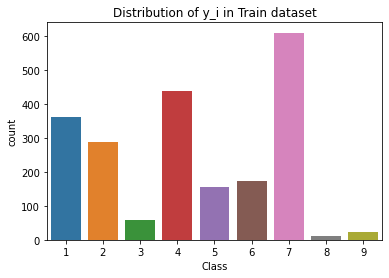

Percentage of points in class 1 in Train dataset is: 17.06742102781707
Percentage of points in class 2 in Train dataset is: 13.625648279113625
Percentage of points in class 3 in Train dataset is: 2.6874115983026874
Percentage of points in class 4 in Train dataset is: 20.697784064120697
Percentage of points in class 5 in Train dataset is: 7.307873644507308
Percentage of points in class 6 in Train dataset is: 8.203677510608204
Percentage of points in class 7 in Train dataset is: 28.71287128712871
Percentage of points in class 8 in Train dataset is: 0.5657708628005658
Percentage of points in class 9 in Train dataset is: 1.1315417256011315


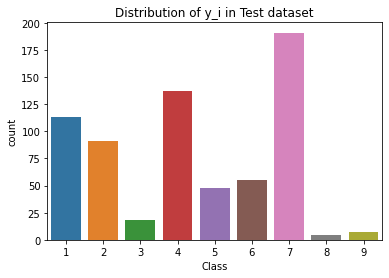

Percentage of points in class 1 in Test dataset is: 17.018072289156628
Percentage of points in class 2 in Test dataset is: 13.704819277108435
Percentage of points in class 3 in Test dataset is: 2.710843373493976
Percentage of points in class 4 in Test dataset is: 20.632530120481928
Percentage of points in class 5 in Test dataset is: 7.228915662650602
Percentage of points in class 6 in Test dataset is: 8.283132530120483
Percentage of points in class 7 in Test dataset is: 28.76506024096386
Percentage of points in class 8 in Test dataset is: 0.6024096385542169
Percentage of points in class 9 in Test dataset is: 1.0542168674698795


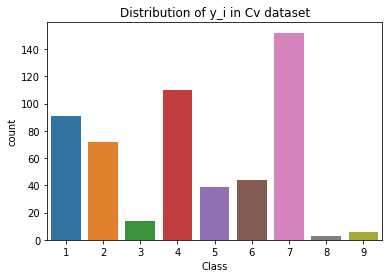

Percentage of points in class 1 in Test dataset is: 17.13747645951036
Percentage of points in class 2 in Test dataset is: 13.559322033898304
Percentage of points in class 3 in Test dataset is: 2.6365348399246704
Percentage of points in class 4 in Test dataset is: 20.715630885122412
Percentage of points in class 5 in Test dataset is: 7.344632768361582
Percentage of points in class 6 in Test dataset is: 8.286252354048965
Percentage of points in class 7 in Test dataset is: 28.625235404896422
Percentage of points in class 8 in Test dataset is: 0.5649717514124294
Percentage of points in class 9 in Test dataset is: 1.1299435028248588


In [32]:
sns.countplot(train_df['Class'].sort_values(ascending=False),label='Count').set_title('Distribution of y_i in Train dataset')
plt.show()
for i in range(1,10):
    print('Percentage of points in class {} in Train dataset is: {}'.format(i,(train_df['Class'].value_counts()[i]/train_df['Class'].value_counts().sum())*100))
    

sns.countplot(test_df['Class'].sort_values(ascending=False),label='Count').set_title('Distribution of y_i in Test dataset')
plt.show()

for i in range(1,10):
    print('Percentage of points in class {} in Test dataset is: {}'.format(i,(test_df['Class'].value_counts()[i]/test_df['Class'].value_counts().sum())*100))
 

sns.countplot(cv_df['Class'].sort_values(ascending=False),label='Count').set_title('Distribution of y_i in Cv dataset')
plt.show()

for i in range(1,10):
    print('Percentage of points in class {} in Test dataset is: {}'.format(i,(cv_df['Class'].value_counts()[i]/cv_df['Class'].value_counts().sum())*100))


Note that only class 7,4,1,2 and 5,6 have most occurring value, pts having classes 3,8,9 do not occur frequently.

## Building a Random Model

In a 'Random' Model, we generate the NINE class probabilites randomly such that they sum to 1.

In [33]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    
    labels = [1,2,3,4,5,6,7,8,9]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

log loss on cross validation set is 2.3877124295886705
log loss on test dataset is 2.329921990757879
-------------------- Confusion matrix --------------------


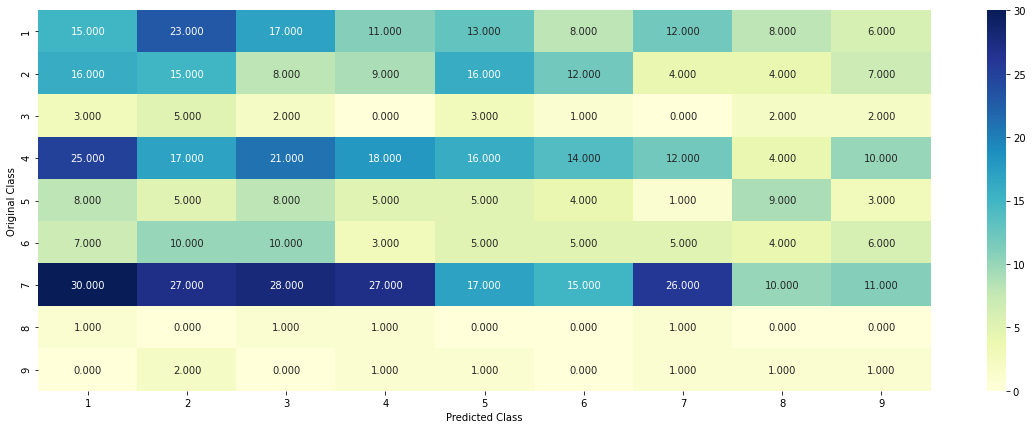

-------------------- Precision matrix (Columm Sum=1) --------------------


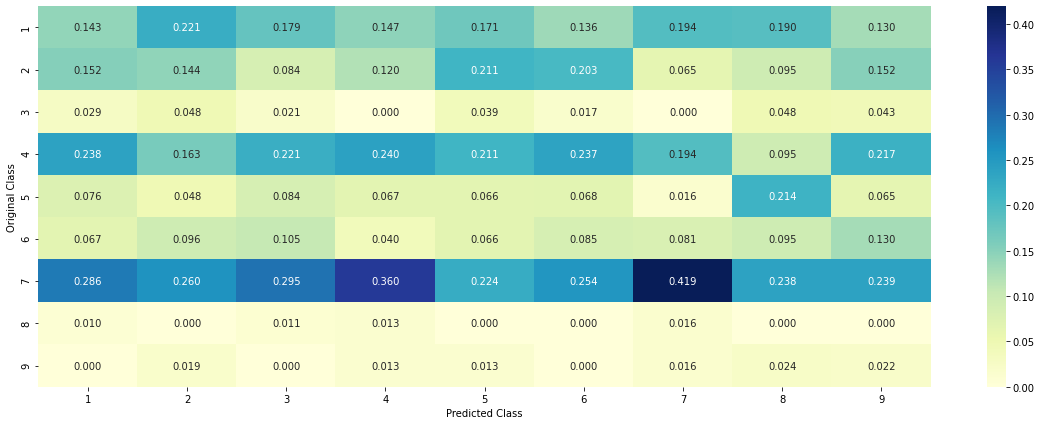

-------------------- Recall matrix (Row sum=1) --------------------


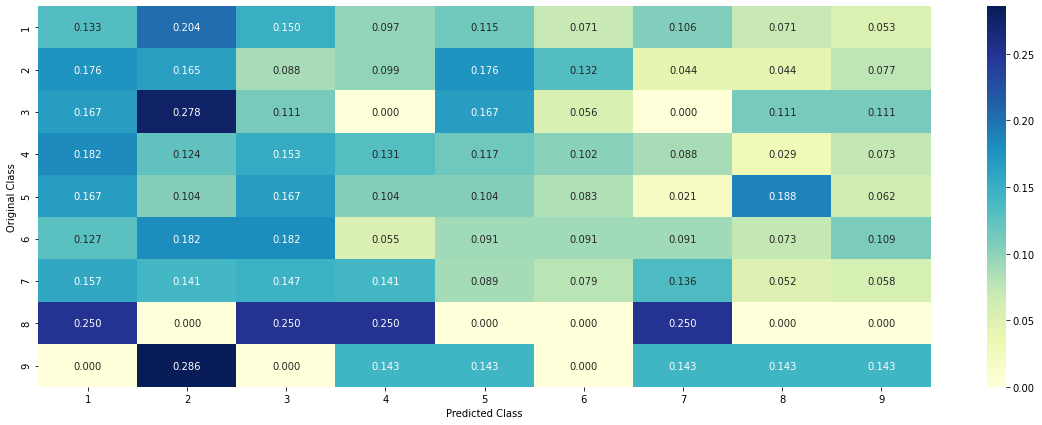

In [34]:
y_pred_cv=[]
for i in range(0,cv_df.shape[0]):
    y_pred_cv.append([np.random.randint(1,10) for j in range(0,9)]) # creating a 9 random integers for 9 classes.
    y_pred_cv[i]=[round(y_pred_cv[i][j]/sum(y_pred_cv[i]),2) for j in range(0,9)] 
# summing all the generated intger for a row and dividing by sum, such that all the values lie between 0 and 1 and can be consif=dered as probability.    
print("log loss on cross validation set is {}".format(log_loss(y_cv,y_pred_cv,eps=1e-15)))
y_pred_test=[]
for i in range(0,test_df.shape[0]):
    y_pred_test.append([np.random.randint(1,10) for j in range(0,9)]) # creating a 9 random integers for 9 classes.
    y_pred_test[i]=[round(y_pred_test[i][j]/sum(y_pred_test[i]),2) for j in range(0,9)] 
# summing all the generated intger for a row and dividing by sum of row, such that all the values lie between 0 and 1 and can be consif=dered as probability.    
print("log loss on test dataset is {}".format(log_loss(y_test,y_pred_test,eps=1e-15)))

#taking the actual class prediction
y_predicted=np.argmax(y_pred_test,axis=1)
plot_confusion_matrix(y_test,y_predicted+1)

Hence we can conclude that in worst case our model will have log-loss of around 2.3. So we need to build a model which will be have log_loss between >0 and <2.35

Precision matrix: Out of all the points that were predicted to be class 1 only 16% of those points belong to class 1. Which is very low

Recall matrix: Out of all the points that originally belong to class 8, 50% of those have been predicted as class 5.

# Univariate Analysis on Gene Feature

## Q1. Gene, What type of feature it is ?

Gene is a categorical variable

## Q2. How many categories are there and How they are distributed?

In [35]:
unique_genes = train_df['Gene'].value_counts()
print('Number of Unique Genes :', unique_genes.shape[0])
# the top 15 genes that occured most
print(unique_genes.head(15))

Number of Unique Genes : 236
BRCA1     166
TP53      110
EGFR       92
BRCA2      84
PTEN       82
KIT        63
BRAF       53
ERBB2      48
PIK3CA     43
PDGFRA     41
ALK        38
FLT3       37
FGFR2      34
TSC2       32
KRAS       28
Name: Gene, dtype: int64


In [36]:
print("There are", unique_genes.shape[0] ,"different categories of genes in the train data, and they are distibuted as follows",)

There are 236 different categories of genes in the train data, and they are distibuted as follows


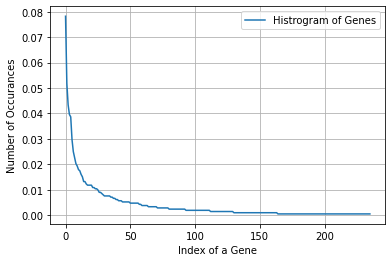

In [37]:
s = sum(unique_genes.values) #train_df.shape[0]
h = unique_genes.values/s
plt.plot(h, label="Histrogram of Genes")
plt.xlabel('Index of a Gene')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()

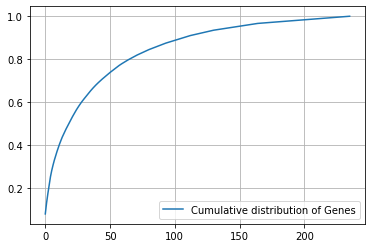

In [38]:
c = np.cumsum(h)
plt.plot(c,label='Cumulative distribution of Genes')
plt.grid()
plt.legend()
plt.show()

This graph shows that almost 50 genes contributes 75% of the data points.
rest 180 points contribute 25% of the data points, This show that there are few genes that occur very frequently and there are many genes that occur very few times.

## Q3. How to featurize this Gene feature ?

there are two ways we can featurize this variable
1. One hot Encoding
2. Response coding
3. Tf-Idf Encoding

We will choose the appropriate featurization based on the ML model we use. For this problem of multi-class classification with categorical features, one-hot encoding is better for Logistic regression while response coding is better for Random Forests.

## Response coding for Gene feature

In [39]:
train_df.head()

,ID,TEXT,Gene,Variation,Class
2552,2552,genetic screening breast ovarian cancer suscep...,BRCA1,V1714G,1
187,187,abstract malignant pleural effusions mpes ofte...,EGFR,L747_P753delinsS,7
1764,1764,introduction somatic mutations human cytosolic...,IDH1,R49C,4
1040,1040,tuberous sclerosis complex tsc autosomal domin...,TSC2,R1200W,4
2778,2778,mutation screening breast ovarian cancer predi...,BRCA2,L2396F,6


In [40]:
train_df.Gene.value_counts()

BRCA1      166
TP53       110
EGFR        92
BRCA2       84
PTEN        82
          ... 
KDM6A        1
H3F3A        1
DUSP4        1
WHSC1L1      1
PAX8         1
Name: Gene, Length: 236, dtype: int64

In [41]:
#train_df.iloc[np.where(train_df['Gene']==train_df.Gene.value_counts().index[0])[0]]  --- same result as below line
train_df[['Gene','Class']][train_df['Gene']==train_df.Gene.value_counts().index[0]]

,Gene,Class
2552,BRCA1,1
2612,BRCA1,5
2488,BRCA1,5
2507,BRCA1,3
2463,BRCA1,1
...,...,...
2535,BRCA1,5
2549,BRCA1,5
2662,BRCA1,5
2472,BRCA1,5


In [42]:
df1=train_df[['Gene','Class']][train_df['Gene']==train_df.Gene.value_counts().index[0]]
df1.Class.value_counts()

5    61
1    40
6    31
4    22
3    12
Name: Class, dtype: int64

In [43]:
alpha=1
for i in range(0,train_df.Gene.value_counts().shape[0]): # looping for each distinct genes present--loops for 233 times
    df1=train_df[['Gene','Class']][train_df['Gene']==train_df.Gene.value_counts().index[i]]
    for j in range(0,df1.Class.value_counts().shape[0]):# looping for number of distinct classes per genes
        Numerator=(df1.Class.value_counts().values[j] + alpha*10)
        denominator=(train_df.Gene.value_counts().values[i]+ 90*alpha) #hen we caculate the probability of a feature belongs to any particular class, we apply laplace smoothing

#(numerator + 10\*alpha) / (denominator + 90\*alpha)

        print('probability of class {} given Gene: {} is : {}'.format(df1.Class.value_counts().index[j],train_df.Gene.value_counts().index[i],np.round(Numerator/denominator,2)))
    

probability of class 5 given Gene: BRCA1 is : 0.28
probability of class 1 given Gene: BRCA1 is : 0.2
probability of class 6 given Gene: BRCA1 is : 0.16
probability of class 4 given Gene: BRCA1 is : 0.12
probability of class 3 given Gene: BRCA1 is : 0.09
probability of class 1 given Gene: TP53 is : 0.32
probability of class 4 given Gene: TP53 is : 0.28
probability of class 6 given Gene: TP53 is : 0.08
probability of class 5 given Gene: TP53 is : 0.06
probability of class 3 given Gene: TP53 is : 0.06
probability of class 2 given Gene: TP53 is : 0.06
probability of class 9 given Gene: TP53 is : 0.06
probability of class 7 given Gene: EGFR is : 0.34
probability of class 2 given Gene: EGFR is : 0.22
probability of class 4 given Gene: EGFR is : 0.08
probability of class 8 given Gene: EGFR is : 0.06
probability of class 6 given Gene: EGFR is : 0.06
probability of class 5 given Gene: EGFR is : 0.06
probability of class 3 given Gene: EGFR is : 0.06
probability of class 1 given Gene: EGFR is : 0

In [44]:
def response_coding(data,feature,alpha):
    dataframe=data.iloc[:,1:] #leaving behind the id feature to escape from function call by reference for passing mutable object
    pr=dict()
    for i in range(0,dataframe[feature].value_counts().shape[0]): # looping for each distinct gene/variation present--loops for 233 times
        df1=dataframe[[feature,'Class']][dataframe[feature]==dataframe[feature].value_counts().index[i]]
        for j in range(0,df1.Class.value_counts().shape[0]):# looping for number of distinct classes per gene/variation
            Numerator=(df1.Class.value_counts().values[j] + alpha*10) #Number of points where class j occurs and a particular gene/variation i occurs
            denominator=(dataframe[feature].value_counts().values[i]+ 90*alpha) #Number of points where gene/variation i occurs
            #Then we caculate the probability of a feature belongs to any particular class, we apply laplace smoothing
            #(numerator + 10\*alpha) / (denominator + 90\*alpha) for laplace smoothing
            pr['({},{})'.format(df1.Class.value_counts().index[j],dataframe[feature].value_counts().index[i])]=np.round(Numerator/denominator,2)
    if feature=='Gene':
        k=1
    else:
        k=2
    for index,row in dataframe.iterrows():
        for j in range(0,9): 
            if '({},{})'.format(j+1,row[k]) in pr.keys():
                dataframe.at[index,'prob of class {}'.format(j+1)]=np.round(pr['({},{})'.format(j+1,row[k])],2)
            else:
                dataframe.at[index,'prob of class {}'.format(j+1)]=np.round(1/9,2)
    dataframe.drop(feature,axis=1,inplace=True)
    return dataframe
    
    

In [45]:
#response-coding of the Gene feature
# alpha is used for laplace smoothing
alpha = 1
#train data with response coded features
train_gene_feature_responseCoding=response_coding(train_df,'Gene',alpha)
train_gene_feature_responseCoding.drop(['TEXT','Variation','Class'],axis=1,inplace=True)
#test data with with response coded features
test_gene_feature_responseCoding=response_coding(test_df,'Gene',alpha)
test_gene_feature_responseCoding.drop(['TEXT','Variation','Class'],axis=1,inplace=True)
#Cross validation data with response coded features
cv_gene_feature_responseCoding=response_coding(cv_df,'Gene',alpha)
cv_gene_feature_responseCoding.drop(['TEXT','Variation','Class'],axis=1,inplace=True)

In [46]:
train_gene_feature_responseCoding.head()

,prob of class 1,prob of class 2,prob of class 3,prob of class 4,prob of class 5,prob of class 6,prob of class 7,prob of class 8,prob of class 9
2552,0.20,0.11,0.09,0.12,0.28,0.16,0.11,0.11,0.11
187,0.06,0.22,0.06,0.08,0.06,0.06,0.34,0.06,0.11
1764,0.11,0.11,0.11,0.14,0.13,0.11,0.11,0.11,0.12
1040,0.20,0.11,0.11,0.21,0.11,0.11,0.09,0.11,0.11
2778,0.13,0.11,0.11,0.07,0.14,0.37,0.11,0.11,0.11


In [47]:
print('Shape of our train data after Respose encoding',train_gene_feature_responseCoding.shape[1])

Shape of our train data after Respose encoding 9


## One-hot Encoding

In [48]:
# one-hot encoding of Gene feature.
gene_vectorizer = CountVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(train_df['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(test_df['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(cv_df['Gene'])

In [49]:
gene_vectorizer.get_feature_names()

['abl1',
 'acvr1',
 'ago2',
 'akt1',
 'akt2',
 'akt3',
 'alk',
 'apc',
 'ar',
 'araf',
 'arid1a',
 'arid1b',
 'arid2',
 'asxl1',
 'atm',
 'atr',
 'atrx',
 'aurka',
 'aurkb',
 'axin1',
 'axl',
 'b2m',
 'bap1',
 'bcl10',
 'bcl2',
 'bcl2l11',
 'bcor',
 'braf',
 'brca1',
 'brca2',
 'brd4',
 'brip1',
 'btk',
 'card11',
 'carm1',
 'casp8',
 'cbl',
 'ccnd1',
 'ccnd2',
 'ccnd3',
 'ccne1',
 'cdh1',
 'cdk12',
 'cdk6',
 'cdkn1a',
 'cdkn1b',
 'cdkn2a',
 'cdkn2b',
 'cdkn2c',
 'cebpa',
 'chek2',
 'cic',
 'crebbp',
 'ctcf',
 'ctla4',
 'ctnnb1',
 'ddr2',
 'dicer1',
 'dnmt3a',
 'dnmt3b',
 'dusp4',
 'egfr',
 'eif1ax',
 'elf3',
 'ep300',
 'epas1',
 'erbb2',
 'erbb3',
 'erbb4',
 'ercc2',
 'ercc3',
 'ercc4',
 'erg',
 'errfi1',
 'esr1',
 'etv1',
 'etv6',
 'ewsr1',
 'ezh2',
 'fam58a',
 'fanca',
 'fancc',
 'fat1',
 'fbxw7',
 'fgf4',
 'fgfr1',
 'fgfr2',
 'fgfr3',
 'fgfr4',
 'flt3',
 'foxa1',
 'foxo1',
 'foxp1',
 'gata3',
 'gli1',
 'gna11',
 'gnas',
 'h3f3a',
 'hla',
 'hnf1a',
 'hras',
 'idh1',
 'idh2',
 'igf1r

In [50]:
print("train_gene_feature_onehotCoding is converted feature using one-hot encoding method. The shape of gene feature:", train_gene_feature_onehotCoding.shape)

train_gene_feature_onehotCoding is converted feature using one-hot encoding method. The shape of gene feature: (2121, 235)


## Tf-idf Encoding

In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer
cv = TfidfVectorizer()
train_gene_feature_Tfidf = cv.fit_transform(train_df['Gene'].values).toarray()
test_gene_feature_Tfidf = cv.transform(test_df['Gene'].values).toarray()
cv_gene_feature_Tfidf = cv.transform(cv_df['Gene'].values).toarray()

In [52]:
len(cv.get_feature_names())

235

## Q4. How good is this gene feature in predicting y_i?

There are many ways to estimate how good a feature is, in predicting y_i. One of the good methods is to build a proper ML model using just this feature. In this case, we will build a logistic regression model using only Gene feature (one hot encoded/Response encoding) to predict y_i.

## Analysing gene feature importance using the One Hot encoded feature

For values of alpha =  1e-05 The log loss is: 1.2238187695785785
For values of alpha =  0.0001 The log loss is: 1.2093540938317056
For values of alpha =  0.001 The log loss is: 1.260742062897305
For values of alpha =  0.01 The log loss is: 1.379693589012197
For values of alpha =  0.1 The log loss is: 1.4698755234491603
For values of alpha =  1 The log loss is: 1.5132097896400942


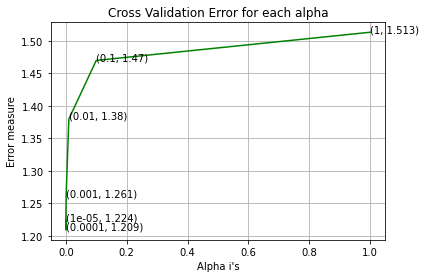

For values of best alpha =  0.0001 The train log loss is: 0.984409205983913
For values of best alpha =  0.0001 The cross validation log loss is: 1.2093540938317056
For values of best alpha =  0.0001 The test log loss is: 1.211250411912684


In [53]:
alpha = [10 ** x for x in range(-5, 1)] # hyperparam for SGD classifier.

# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_gene_feature_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_gene_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_gene_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_gene_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


Since the log loss on test data(1.16) is significantly less than the log loss of random model(2.4), so we can say that gene feature definately adds value to our data and it is an important feature.

## Analysing gene feature importance using the Response encoded feature

For values of alpha =  1e-05 The log loss is: 1.40840389341872
For values of alpha =  0.0001 The log loss is: 1.4529004284336986
For values of alpha =  0.001 The log loss is: 1.5105570762097194
For values of alpha =  0.01 The log loss is: 1.5342468754401422
For values of alpha =  0.1 The log loss is: 1.555265803628446
For values of alpha =  1 The log loss is: 1.5767113137244064


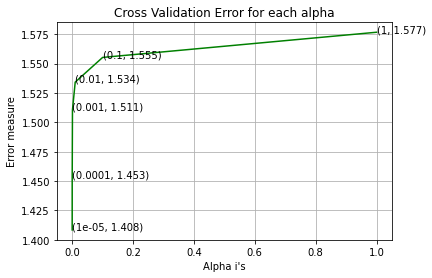

For values of best alpha =  1e-05 The train log loss is: 1.2044724655173522
For values of best alpha =  1e-05 The cross validation log loss is: 1.40840389341872
For values of best alpha =  1e-05 The test log loss is: 1.3717828873018731


In [54]:
alpha = [10 ** x for x in range(-5, 1)] # hyperparam for SGD classifier.

# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_gene_feature_responseCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_gene_feature_responseCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_gene_feature_responseCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_gene_feature_responseCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_gene_feature_responseCoding, y_train)

predict_y = sig_clf.predict_proba(train_gene_feature_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_gene_feature_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_gene_feature_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


##  Analysing gene feature importance using the Tf-idf encoded feature 

For values of alpha =  1e-05 The log loss is: 1.223574090687288
For values of alpha =  0.0001 The log loss is: 1.2084469412003835
For values of alpha =  0.001 The log loss is: 1.2587952005420557
For values of alpha =  0.01 The log loss is: 1.3608918202138003
For values of alpha =  0.1 The log loss is: 1.4053953981095637
For values of alpha =  1 The log loss is: 1.430016102350082


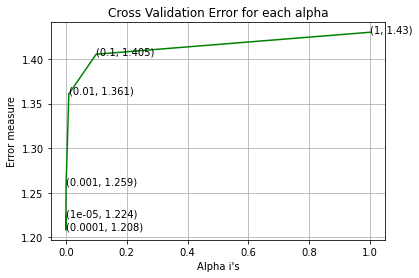

For values of best alpha =  0.0001 The train log loss is: 0.9835404165761049
For values of best alpha =  0.0001 The cross validation log loss is: 1.2084469412003835
For values of best alpha =  0.0001 The test log loss is: 1.211217541454516


In [55]:
alpha = [10 ** x for x in range(-5, 1)] # hyperparam for SGD classifier.

# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_gene_feature_Tfidf, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_gene_feature_Tfidf, y_train)
    predict_y = sig_clf.predict_proba(cv_gene_feature_Tfidf)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_gene_feature_Tfidf, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_gene_feature_Tfidf, y_train)

predict_y = sig_clf.predict_proba(train_gene_feature_Tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_gene_feature_Tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_gene_feature_Tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


#### we can conclude that Tf-idf coded features computed ,reduces much more log loss than the one hot encoded features and response coded feature. 

## Q5. Is the Gene feature stable across all the data sets (Test, Train, Cross validation)?

Yes, it is. Otherwise, the CV and Test errors would be significantly more than train error. 

In [56]:
print("Q6. How many data points in Test and CV datasets are covered by the ", train_df.Gene.value_counts().shape[0], " genes in train dataset?")

test_coverage=test_df[test_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]
cv_coverage=cv_df[cv_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]

print('Ans\n1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)

Q6. How many data points in Test and CV datasets are covered by the  236  genes in train dataset?
Ans
1. In test data 646 out of 664 : 97.28915662650603
2. In cross validation data 518 out of  531 : 97.5517890772128


## Univariate Analysis on Variation Feature

## Q1. Variation, What type of feature is it ?

 Variation is a categorical variable

## Q2. How many categories are there?

In [57]:
print('Number of unique variations in train data',train_df.Variation.value_counts().shape[0])
# the top 10 variations that occured most
print(train_df.Variation.value_counts().head(10))

Number of unique variations in train data 1940
Truncating Mutations    62
Amplification           42
Deletion                40
Fusions                 19
Overexpression           5
A146T                    2
V321M                    2
T58I                     2
EWSR1-ETV1 Fusion        2
Q22K                     2
Name: Variation, dtype: int64


In [58]:
print("There are",train_df.Variation.value_counts().shape[0] ,"different categories of variations in the train data, and they are distibuted as follows",)

There are 1940 different categories of variations in the train data, and they are distibuted as follows


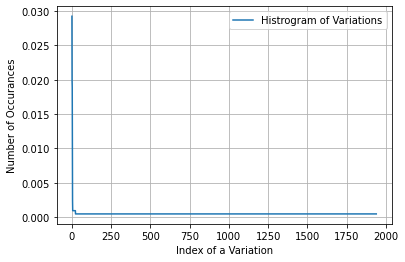

In [59]:
s = sum(train_df.Variation.value_counts().values);
h = train_df.Variation.value_counts().values/s;
plt.plot(h, label="Histrogram of Variations") # decreasing order of frequency
plt.xlabel('Index of a Variation')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()

There are very few, infact only 4 categories that occur frequently, rest occurs almost once.

[0.02923149 0.04903347 0.0678925  ... 0.99905705 0.99952852 1.        ]


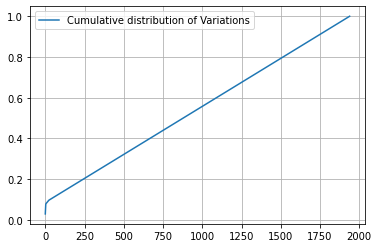

In [60]:
c = np.cumsum(h)
print(c)
plt.plot(c,label='Cumulative distribution of Variations')
plt.grid()
plt.legend()
plt.show()

This cumulative distribution shows that most of the categories occur very less times..once or twice

## Q3. How to featurize this Variation feature ?

Ans.There are two ways we can featurize this variable.

1. One hot Encoding
2. Response coding
3. Tfidf encoding

We will be using both these methods to featurize the Variation Feature

## Response coding for Variation feature

In [61]:
#response-coding of the Gene feature
# alpha is used for laplace smoothing
alpha = 1
#train data with response coded features
train_variation_feature_responseCoding=response_coding(train_df,'Variation',alpha)
train_variation_feature_responseCoding.drop(['TEXT','Gene','Class'],axis=1,inplace=True)
#test data with with response coded features
test_variation_feature_responseCoding=response_coding(test_df,'Variation',alpha)
test_variation_feature_responseCoding.drop(['TEXT','Gene','Class'],axis=1,inplace=True)
#Cross validation data with response coded features
cv_variation_feature_responseCoding=response_coding(cv_df,'Variation',alpha)
cv_variation_feature_responseCoding.drop(['TEXT','Gene','Class'],axis=1,inplace=True)

In [62]:
train_variation_feature_responseCoding.head()

,prob of class 1,prob of class 2,prob of class 3,prob of class 4,prob of class 5,prob of class 6,prob of class 7,prob of class 8,prob of class 9
2552,0.12,0.11,0.11,0.11,0.11,0.11,0.11,0.11,0.11
187,0.11,0.11,0.11,0.11,0.11,0.11,0.12,0.11,0.11
1764,0.11,0.11,0.11,0.12,0.11,0.11,0.11,0.11,0.11
1040,0.11,0.11,0.11,0.12,0.11,0.11,0.11,0.11,0.11
2778,0.11,0.11,0.11,0.11,0.11,0.12,0.11,0.11,0.11


In [63]:
print("train_variation_feature_responseCoding is a converted feature using the response coding method. The shape of Variation feature:", train_variation_feature_responseCoding.shape)

train_variation_feature_responseCoding is a converted feature using the response coding method. The shape of Variation feature: (2121, 9)


## One Hot Encoding for variation feature

In [64]:
# one-hot encoding of variation feature.
variation_vectorizer = CountVectorizer()
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(train_df['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(test_df['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(cv_df['Variation'])

In [65]:
print("train_variation_feature_onehotEncoded is converted feature using the one-hot encoding method. The shape of Variation feature:", train_variation_feature_onehotCoding.shape)

train_variation_feature_onehotEncoded is converted feature using the one-hot encoding method. The shape of Variation feature: (2121, 1976)


## Tf-idf encoding for variation feature

In [66]:
from sklearn.feature_extraction.text import TfidfVectorizer
cv = TfidfVectorizer()
train_variation_feature_Tfidf = cv.fit_transform(train_df['Variation'].values).toarray()
test_variation_feature_Tfidf = cv.transform(test_df['Variation'].values).toarray()
cv_variation_feature_Tfidf = cv.transform(cv_df['Variation'].values).toarray()

In [67]:
len(cv.get_feature_names())

1976

## Q4. How good is this Varitaion feature in predicting y_i?

There are many ways to estimate how good a feature is, in predicting y_i. One of the good methods is to build a proper ML model using just this feature. In this case, we will build a logistic regression model using only Variation feature (one hot encoded/Response encoding) to predict y_i.

## Analysing Variation feature importance using the One Hot encoded feature

For values of alpha =  1e-05 The log loss is: 1.7157993118280348
For values of alpha =  0.0001 The log loss is: 1.7107109087644836
For values of alpha =  0.001 The log loss is: 1.722937023237808
For values of alpha =  0.01 The log loss is: 1.7346300037371343
For values of alpha =  0.1 The log loss is: 1.735211682062318
For values of alpha =  1 The log loss is: 1.7376416113689024


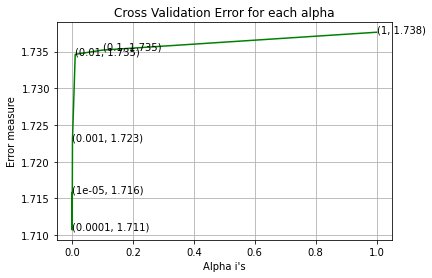

For values of best alpha =  0.0001 The train log loss is: 0.7047273983627832
For values of best alpha =  0.0001 The cross validation log loss is: 1.7107109087644836
For values of best alpha =  0.0001 The test log loss is: 1.6704960887360194


In [68]:
alpha = [10 ** x for x in range(-5, 1)] # hyperparam for SGD classifier.

# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_variation_feature_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_variation_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_variation_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_variation_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


Since the log loss on test data(1.67) is significantly less than the log loss of random model(2.4), so we can say that Varitaion feature definately adds value to our data and it is an important feature.

This also shows that our data is overfitting using the one hot encoded feature and there could be much instability in this "Variation" feature.

## Analysing Variation feature importance using the Response encoded feature

In [69]:
train_variation_feature_responseCoding.head()

,prob of class 1,prob of class 2,prob of class 3,prob of class 4,prob of class 5,prob of class 6,prob of class 7,prob of class 8,prob of class 9
2552,0.12,0.11,0.11,0.11,0.11,0.11,0.11,0.11,0.11
187,0.11,0.11,0.11,0.11,0.11,0.11,0.12,0.11,0.11
1764,0.11,0.11,0.11,0.12,0.11,0.11,0.11,0.11,0.11
1040,0.11,0.11,0.11,0.12,0.11,0.11,0.11,0.11,0.11
2778,0.11,0.11,0.11,0.11,0.11,0.12,0.11,0.11,0.11


For values of alpha =  1e-05 The log loss is: 0.37822263554775915
For values of alpha =  0.0001 The log loss is: 0.5668958451146945
For values of alpha =  0.001 The log loss is: 0.7941996998334546
For values of alpha =  0.01 The log loss is: 0.8710862734614279
For values of alpha =  0.1 The log loss is: 0.9829759298474593
For values of alpha =  1 The log loss is: 1.4177119432505125


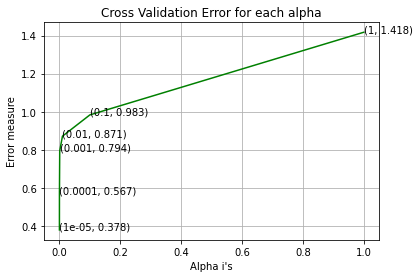

For values of best alpha =  1e-05 The train log loss is: 0.3793613647871706
For values of best alpha =  1e-05 The cross validation log loss is: 0.37822263554775915
For values of best alpha =  1e-05 The test log loss is: 0.36609895779000756


In [70]:
alpha = [10 ** x for x in range(-5, 1)] # hyperparam for SGD classifier.

# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_variation_feature_responseCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_variation_feature_responseCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_variation_feature_responseCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_variation_feature_responseCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_variation_feature_responseCoding, y_train)

predict_y = sig_clf.predict_proba(train_variation_feature_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_variation_feature_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_variation_feature_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


## Analysing Variation feature importance using the Tf-idf encoded feature

For values of alpha =  1e-05 The log loss is: 1.7145245360746735
For values of alpha =  0.0001 The log loss is: 1.7140190331683398
For values of alpha =  0.001 The log loss is: 1.7305631796784209
For values of alpha =  0.01 The log loss is: 1.739896600065931
For values of alpha =  0.1 The log loss is: 1.7416238102582917
For values of alpha =  1 The log loss is: 1.743925021265211


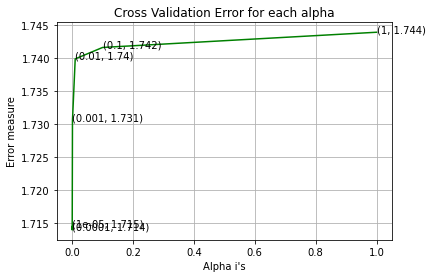

For values of best alpha =  0.0001 The train log loss is: 0.6539255609030581
For values of best alpha =  0.0001 The cross validation log loss is: 1.7140190331683398
For values of best alpha =  0.0001 The test log loss is: 1.6683306419110995


In [71]:
alpha = [10 ** x for x in range(-5, 1)] # hyperparam for SGD classifier.

# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_variation_feature_Tfidf, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_variation_feature_Tfidf, y_train)
    predict_y = sig_clf.predict_proba(cv_variation_feature_Tfidf)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_variation_feature_Tfidf, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_variation_feature_Tfidf, y_train)

predict_y = sig_clf.predict_proba(train_variation_feature_Tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_variation_feature_Tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_variation_feature_Tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


#### we can conclude that New Response coded features computed  reduces much more log loss than the one hot encoded features. Hence we will use response coded feature going forward. Also, the log loss is significantly less than the Random model, Hence Variation is much important feature. 

Using Response encoding our model with response coded featues are not overfitted.

## Q5. Is the Variation feature stable across all the data sets (Test, Train, Cross validation)?

Not sure! But lets be very sure using the below analysis. 

In [72]:
print("Q12. How many data points are covered by total ", train_df['Variation'].value_counts().shape[0], " Variation in test and cross validation data sets?")
test_coverage=test_df[test_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]
cv_coverage=cv_df[cv_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]
print('Ans\n1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)

Q12. How many data points are covered by total  1940  Variation in test and cross validation data sets?
Ans
1. In test data 78 out of 664 : 11.74698795180723
2. In cross validation data 61 out of  531 : 11.487758945386064


The above analysis shows that our data is highly unstable across all three datasets.
But since we are getting significantly less log loss than the log loss of random model. Hence, The Variation feature definately adds value to our model and we will keep this feature

# Univariate Analysis on Text Feature

1. How many unique words are present in train data?
2. How are word frequencies distributed?
3. How to featurize text field?
4. Is the text feature useful in predicitng y_i?
5. Is the text feature stable across train, test and CV datasets?

### Computing OneHot encoding and Response codingfor TEXT feature

In [73]:
# cls_text is a data frame
# for every row in data fram consider the 'TEXT'
# split the words by space
# make a dict with those words
# increment its count whenever we see that word

def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] +=1
    return dictionary

In [74]:
import math
#https://stackoverflow.com/a/1602964
def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],9))
    for i in range(0,9):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['TEXT'].split():
                sum_prob += math.log(((dict_list[i].get(word,0)+10 )/(total_dict.get(word,0)+90)))
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['TEXT'].split()))
            row_index += 1
    return text_feature_responseCoding

In [75]:
# building a CountVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = CountVectorizer(min_df=3)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['TEXT'])
# getting all the feature names (words)
train_text_features= text_vectorizer.get_feature_names()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))


print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 53252


In [76]:
dict_list = []
# dict_list =[] contains 9 dictoinaries each corresponds to a class
for i in range(1,10):
    cls_text = train_df[train_df['Class']==i]
    # build a word dict based on the words in that class
    dict_list.append(extract_dictionary_paddle(cls_text))
    # append it to dict_list

# dict_list[i] is build on i'th  class text data
# total_dict is buid on whole training text data
total_dict = extract_dictionary_paddle(train_df)


## Response coding for TEXT feature

In [77]:
#response coding of text features
train_text_feature_responseCoding  = get_text_responsecoding(train_df)
test_text_feature_responseCoding  = get_text_responsecoding(test_df)
cv_text_feature_responseCoding  = get_text_responsecoding(cv_df)

In [78]:
train_text_feature_responseCoding.shape

(2121, 9)

In [79]:
# https://stackoverflow.com/a/16202486
# we convert each row values such that they sum to 1  # Normalizing the response coded feature
train_text_feature_responseCoding = (train_text_feature_responseCoding.T/train_text_feature_responseCoding.sum(axis=1)).T
test_text_feature_responseCoding = (test_text_feature_responseCoding.T/test_text_feature_responseCoding.sum(axis=1)).T
cv_text_feature_responseCoding = (cv_text_feature_responseCoding.T/cv_text_feature_responseCoding.sum(axis=1)).T

In [80]:
# normalize every feature
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_onehotCoding = text_vectorizer.transform(test_df['TEXT'])

test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding = text_vectorizer.transform(cv_df['TEXT'])

cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

In [81]:

sorted_text_fea_dict = dict(sorted(text_fea_dict.items(), key=lambda x: x[1] , reverse=True))
sorted_text_occur = np.array(list(sorted_text_fea_dict.values()))

In [82]:
# Number of words for a given frequency.
print(Counter(sorted_text_occur))

Counter({3: 5705, 4: 3334, 5: 3062, 6: 2866, 7: 2293, 9: 2036, 8: 1793, 10: 1517, 12: 1276, 14: 931, 11: 907, 16: 829, 13: 817, 15: 786, 17: 711, 18: 708, 20: 622, 24: 591, 21: 571, 19: 482, 22: 438, 23: 394, 26: 373, 28: 360, 27: 353, 30: 344, 48: 335, 25: 334, 29: 306, 31: 272, 32: 268, 49: 261, 33: 252, 36: 249, 34: 234, 40: 230, 39: 228, 42: 225, 35: 224, 41: 205, 38: 198, 45: 197, 37: 196, 52: 182, 43: 177, 47: 168, 54: 166, 50: 158, 44: 156, 46: 153, 63: 150, 60: 148, 56: 146, 51: 144, 55: 130, 53: 128, 57: 126, 58: 121, 82: 110, 72: 108, 59: 106, 64: 100, 69: 99, 62: 98, 65: 97, 67: 96, 84: 94, 68: 93, 66: 89, 78: 86, 61: 85, 91: 83, 73: 83, 71: 83, 83: 81, 81: 80, 70: 80, 76: 78, 85: 76, 75: 73, 80: 71, 79: 71, 96: 70, 74: 70, 92: 69, 87: 69, 104: 68, 98: 66, 93: 66, 99: 65, 90: 64, 86: 62, 110: 61, 101: 59, 126: 57, 97: 57, 106: 56, 77: 56, 88: 55, 100: 53, 95: 53, 108: 52, 94: 51, 107: 50, 121: 48, 109: 47, 114: 46, 112: 46, 136: 45, 118: 45, 105: 45, 89: 45, 128: 44, 123: 44

## Tf-idf Encoding

In [83]:
from sklearn.feature_extraction.text import TfidfVectorizer
cv = TfidfVectorizer(min_df=3)
train_text_feature_Tfidf = cv.fit_transform(train_df['TEXT'].values).toarray()
test_text_feature_Tfidf = cv.transform(test_df['TEXT'].values).toarray()
cv_text_feature_Tfidf = cv.transform(cv_df['TEXT'].values).toarray()

In [84]:
len(cv.get_feature_names())

53252

In [85]:
#normalizing
train_text_feature_Tfidf = normalize(train_text_feature_Tfidf, axis=0)

test_text_feature_Tfidf = normalize(test_text_feature_Tfidf, axis=0)

cv_text_feature_Tfidf = normalize(cv_text_feature_Tfidf, axis=0)

## Analysing the TEXT feature using Onehot Encoding

For values of alpha =  1e-05 The log loss is: 1.265433323428204
For values of alpha =  0.0001 The log loss is: 1.1649700432450647
For values of alpha =  0.001 The log loss is: 1.1686666586182828
For values of alpha =  0.01 The log loss is: 1.3108652907445488
For values of alpha =  0.1 The log loss is: 1.5307204195028499
For values of alpha =  1 The log loss is: 1.6876010353414541


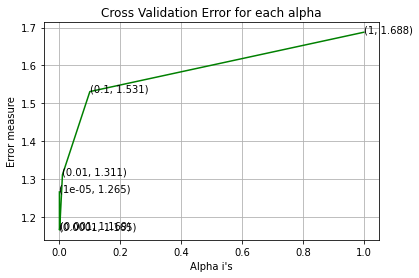

For values of best alpha =  0.0001 The train log loss is: 0.6606560614922411
For values of best alpha =  0.0001 The cross validation log loss is: 1.1649700432450647
For values of best alpha =  0.0001 The test log loss is: 1.2143698826678406


In [86]:
# Train a Logistic regression+Calibration model using text features whicha re on-hot encoded
alpha = [10 ** x for x in range(-5, 1)]

# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)


cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_text_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_text_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_text_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


We can clearly see that we are overfitting

## Analysing the TEXT feature using the response coded feature

For values of alpha =  1e-05 The log loss is: 1.1729742031734827
For values of alpha =  0.0001 The log loss is: 1.1938683545111797
For values of alpha =  0.001 The log loss is: 1.3167845192068177
For values of alpha =  0.01 The log loss is: 1.369066038669305
For values of alpha =  0.1 The log loss is: 1.3887255775474123
For values of alpha =  1 The log loss is: 1.4041826724838464


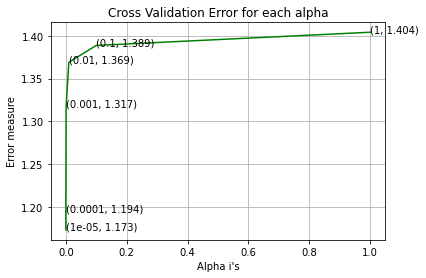

For values of best alpha =  1e-05 The train log loss is: 0.8562737859923198
For values of best alpha =  1e-05 The cross validation log loss is: 1.1729742031734827
For values of best alpha =  1e-05 The test log loss is: 1.1713280234411443


In [87]:
# Train a Logistic regression+Calibration model using text features 
alpha = [10 ** x for x in range(-5, 1)]

# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)


cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_text_feature_responseCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_text_feature_responseCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_text_feature_responseCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_text_feature_responseCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_responseCoding, y_train)

predict_y = sig_clf.predict_proba(train_text_feature_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_text_feature_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_text_feature_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


Our Response coded features work well and the cross validation loss is (1.08) is significantly lower than random model's log error(2.5) Hence, we will use this feature for final modeliing.

# Analysing the TEXT feature using the Tf-idf features

#### Using same tf-idf used in training to compute the tfidf for cv and test data

For values of alpha =  1e-05 The log loss is: 1.2587997589509439
For values of alpha =  0.0001 The log loss is: 1.0797930308863852
For values of alpha =  0.001 The log loss is: 1.0411681173591083
For values of alpha =  0.01 The log loss is: 1.0545508583501824
For values of alpha =  0.1 The log loss is: 1.1090113028425512
For values of alpha =  1 The log loss is: 1.2751888357182637


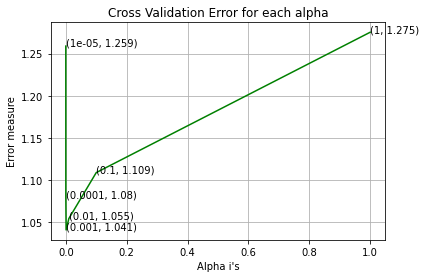

For values of best alpha =  0.001 The train log loss is: 0.5677868411580735
For values of best alpha =  0.001 The cross validation log loss is: 1.0411681173591083
For values of best alpha =  0.001 The test log loss is: 1.0567229917098468


In [88]:
# Train a Logistic regression+Calibration model using text features 
alpha = [10 ** x for x in range(-5, 1)]

# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)


cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_text_feature_Tfidf, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_text_feature_Tfidf, y_train)
    predict_y = sig_clf.predict_proba(cv_text_feature_Tfidf)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_text_feature_Tfidf, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_Tfidf, y_train)

predict_y = sig_clf.predict_proba(train_text_feature_Tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_text_feature_Tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_text_feature_Tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


Not exactly overfitting but, overall Tf-idf encoding works best among all.

#### Q.5  Is the Text feature stable across all the data sets (Test, Train, Cross validation)?

 Yes, it seems like!, As we are not overfitting the model

In [89]:
def get_intersec_text(df):
    df_text_vec = CountVectorizer(min_df=3)
    df_text_fea = df_text_vec.fit_transform(df['TEXT'])
    df_text_features = df_text_vec.get_feature_names()

    df_text_fea_counts = df_text_fea.sum(axis=0).A1
    df_text_fea_dict = dict(zip(list(df_text_features),df_text_fea_counts))
    len1 = len(set(df_text_features))
    len2 = len(set(train_text_features) & set(df_text_features))
    return len1,len2

# Analysis of TEXT feature using

Text clearning can also be done using packages like clean-text, text hero,--tfidf features can be reduced in the dimensions 
using PCA further clustering can be applied to see the scatter plot whether the data is linearly sepearble or not.

## Data Preparation

In [91]:
#Data preparation for ML models.

#Misc. functionns for ML models


def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

In [92]:
# For computing the log loss
def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

In [93]:
# for the given indices, we will print the name of the features
# and we will check whether the feature present in the test point text or not
def get_impfeature_names(indices, text, gene, var, no_features):
    gene_count_vec = CountVectorizer()
    var_count_vec = CountVectorizer()
    text_count_vec = CountVectorizer(min_df=3)
    
    gene_vec = gene_count_vec.fit_transform(train_df['Gene'])
    var_vec  = var_count_vec.fit_transform(train_df['Variation'])
    text_vec = text_count_vec.fit_transform(train_df['TEXT'])
    
    fea1_len = len(gene_count_vec.get_feature_names())
    fea2_len = len(var_count_vec.get_feature_names())
    
    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_count_vec.get_feature_names()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_count_vec.get_feature_names()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_count_vec.get_feature_names()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ",no_features," features ", word_present, "are present in query point")

In [94]:
# merging gene, variance and text features

# building train, test and cross validation data sets
# a = [[1, 2], 
#      [3, 4]]
# b = [[4, 5], 
#      [6, 7]]
# hstack(a, b) = [[1, 2, 4, 5],
#                [ 3, 4, 6, 7]]

train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr() # .tocsr() Compressed Sparse Row matrix
train_y = np.array(list(train_df['Class'])) # used in finding K-Nearest Neighbor in KNN

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(test_df['Class'])) # used in finding K-Nearest Neighbor in KNN

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(cv_df['Class'])) # used in finding K-Nearest Neighbor in KNN


train_gene_var_responseCoding = np.hstack((train_gene_feature_responseCoding,train_variation_feature_responseCoding))
test_gene_var_responseCoding = np.hstack((test_gene_feature_responseCoding,test_variation_feature_responseCoding))
cv_gene_var_responseCoding = np.hstack((cv_gene_feature_responseCoding,cv_variation_feature_responseCoding))

train_x_responseCoding = np.hstack((train_gene_var_responseCoding, train_text_feature_responseCoding))
test_x_responseCoding = np.hstack((test_gene_var_responseCoding, test_text_feature_responseCoding))
cv_x_responseCoding = np.hstack((cv_gene_var_responseCoding, cv_text_feature_responseCoding))

train_gene_var_Tfidf = np.hstack((train_gene_feature_Tfidf,train_variation_feature_Tfidf))
test_gene_var_Tfidf = np.hstack((test_gene_feature_Tfidf,test_variation_feature_Tfidf))
cv_gene_var_Tfidf = np.hstack((cv_gene_feature_Tfidf,cv_variation_feature_Tfidf))


train_x_Tfidf = np.hstack((train_gene_var_Tfidf, train_text_feature_Tfidf))
test_x_Tfidf = np.hstack((test_gene_var_Tfidf, test_text_feature_Tfidf))
cv_x_Tfidf = np.hstack((cv_gene_var_Tfidf, cv_text_feature_Tfidf))


In [95]:
print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_onehotCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_onehotCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_onehotCoding.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (2121, 55463)
(number of data points * number of features) in test data =  (664, 55463)
(number of data points * number of features) in cross validation data = (531, 55463)


In [96]:
print(" Response encoding features :")
print("(number of data points * number of features) in train data = ", train_x_responseCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_responseCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_responseCoding.shape)

 Response encoding features :
(number of data points * number of features) in train data =  (2121, 27)
(number of data points * number of features) in test data =  (664, 27)
(number of data points * number of features) in cross validation data = (531, 27)


In [97]:
print(" Tfidf encoding features :")
print("(number of data points * number of features) in train data = ", train_x_Tfidf.shape)
print("(number of data points * number of features) in test data = ", test_x_Tfidf.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_Tfidf.shape)

 Tfidf encoding features :
(number of data points * number of features) in train data =  (2121, 55463)
(number of data points * number of features) in test data =  (664, 55463)
(number of data points * number of features) in cross validation data = (531, 55463)


# Baseline model

### 1.Naive Bayes

### Hyper parameter tuning using OneHot encoding

for alpha = 1e-05
Log Loss : 1.3086051294328114
for alpha = 0.0001
Log Loss : 1.3114931753923116
for alpha = 0.001
Log Loss : 1.3005399679307592
for alpha = 0.1
Log Loss : 1.2769395363462162
for alpha = 1
Log Loss : 1.2561022676752291
for alpha = 10
Log Loss : 1.3581801955071766
for alpha = 100
Log Loss : 1.3900821051736754
for alpha = 1000
Log Loss : 1.311567127507296


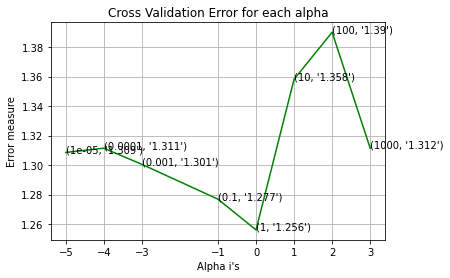

For values of best alpha =  1 The train log loss is: 0.9077934369746669
For values of best alpha =  1 The cross validation log loss is: 1.2561022676752291
For values of best alpha =  1 The test log loss is: 1.2765359910365133


In [98]:

# default paramters
# sklearn.naive_bayes.MultinomialNB(alpha=1.0, fit_prior=True, class_prior=None)

# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)


alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, y_train)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(y_cv, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, y_train)


predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


### Testing the model with best hyper paramters

Log Loss : 1.2765359910365133
Number of missclassified point : 38.403614457831324
-------------------- Confusion matrix --------------------


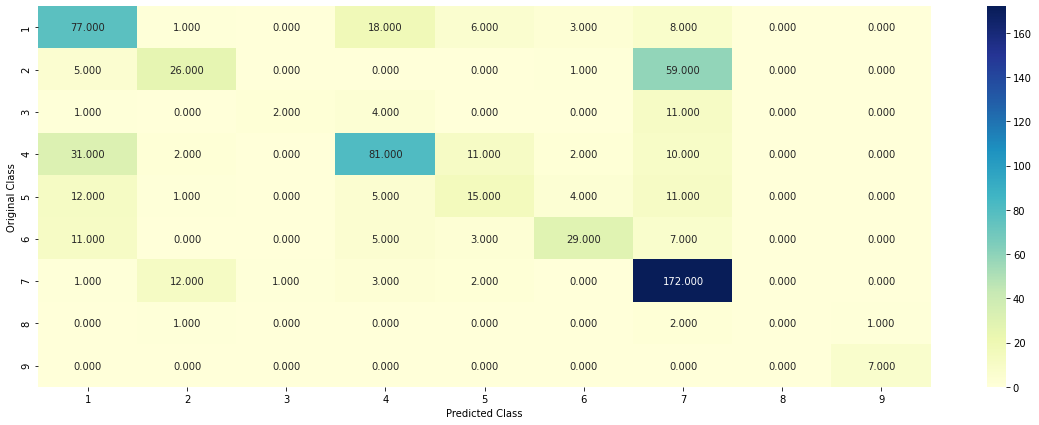

-------------------- Precision matrix (Columm Sum=1) --------------------


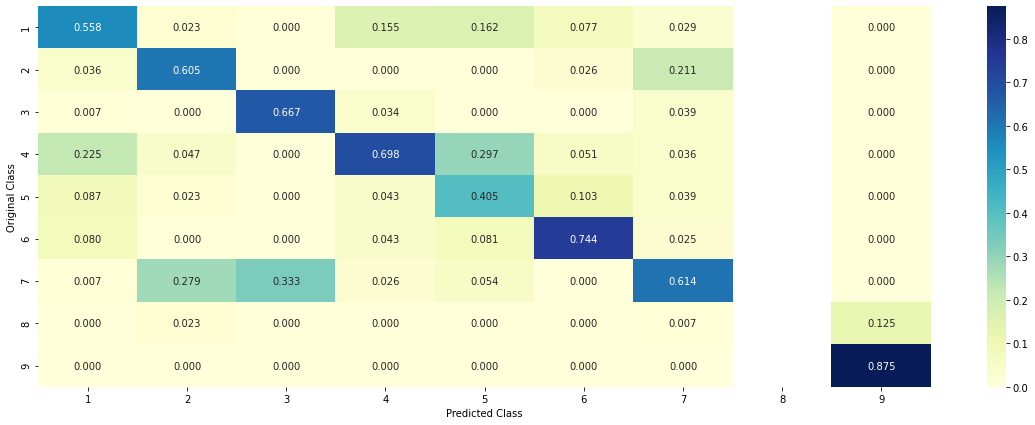

-------------------- Recall matrix (Row sum=1) --------------------


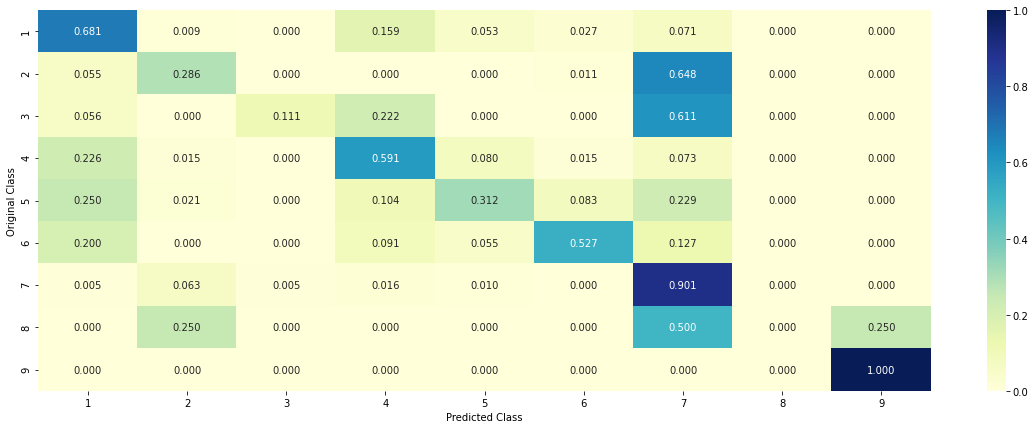

In [99]:
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, y_train)
sig_clf_probs = sig_clf.predict_proba(test_x_onehotCoding)
# to avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss :",log_loss(y_test, sig_clf_probs))
print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(test_x_onehotCoding)- y_test))/y_test.shape[0]*100)
plot_confusion_matrix(y_test, sig_clf.predict(test_x_onehotCoding.toarray()))

## Feature Importance, Incorrectly classified point

In [100]:
test_point_index = 100
test_x_onehotCoding[test_point_index].shape

(1, 55463)

In [101]:
test_point_index = 100
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices=np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature] 
# returns the indices of the top 100 features used in predicting the predicted_cls
print("-"*50)

#feature_imp=[]

#feature_imp=[clf.feature_log_prob_[i, :].argsort() for i in range(0,9)]
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index].lower(),test_df['Variation'].iloc[test_point_index].lower(), no_feature)
#get_impfeature_names(feature_imp[predicted_cls[0]-1][no_feature:], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index].lower(),test_df['Variation'].iloc[test_point_index], no_feature)
#print(np.take(count_vect.get_feature_names(), neg_class_prob_sorted[:10]))
#print(np.take(count_vect.get_feature_names(), pos_class_prob_sorted[:10]))

Predicted Class : 1
Predicted Class Probabilities: [[0.6018 0.0945 0.025  0.0995 0.0569 0.0389 0.0706 0.0072 0.0056]]
Actual Class : 1
--------------------------------------------------
Out of the top  100  features  0 are present in query point


## Hyper parameter tuning using Tfidf encoding

for alpha = 1e-05
Log Loss : 1.287279523609506
for alpha = 0.0001
Log Loss : 1.2865954344637651
for alpha = 0.001
Log Loss : 1.2787287803325038
for alpha = 0.1
Log Loss : 1.2677590435529318
for alpha = 1
Log Loss : 1.231213986980314
for alpha = 10
Log Loss : 1.3126123563593233
for alpha = 100
Log Loss : 1.262096325206198
for alpha = 1000
Log Loss : 1.2157394259200929


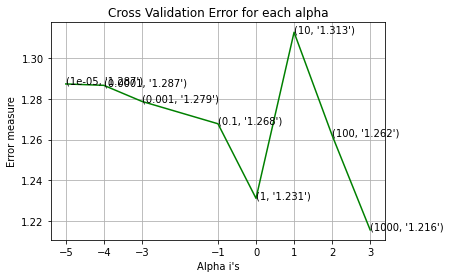

For values of best alpha =  1000 The train log loss is: 0.9139342453099857
For values of best alpha =  1000 The cross validation log loss is: 1.2157394259200929
For values of best alpha =  1000 The test log loss is: 1.20293415740008


In [102]:

# default paramters
# sklearn.naive_bayes.MultinomialNB(alpha=1.0, fit_prior=True, class_prior=None)

# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)


alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_Tfidf, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_Tfidf, y_train)
    sig_clf_probs = sig_clf.predict_proba(cv_x_Tfidf)
    cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(y_cv, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_Tfidf, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_Tfidf, y_train)


predict_y = sig_clf.predict_proba(train_x_Tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_Tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_Tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


## Testing the model with best hyper paramters

Log Loss : 1.20293415740008
Number of missclassified point : 43.373493975903614
-------------------- Confusion matrix --------------------


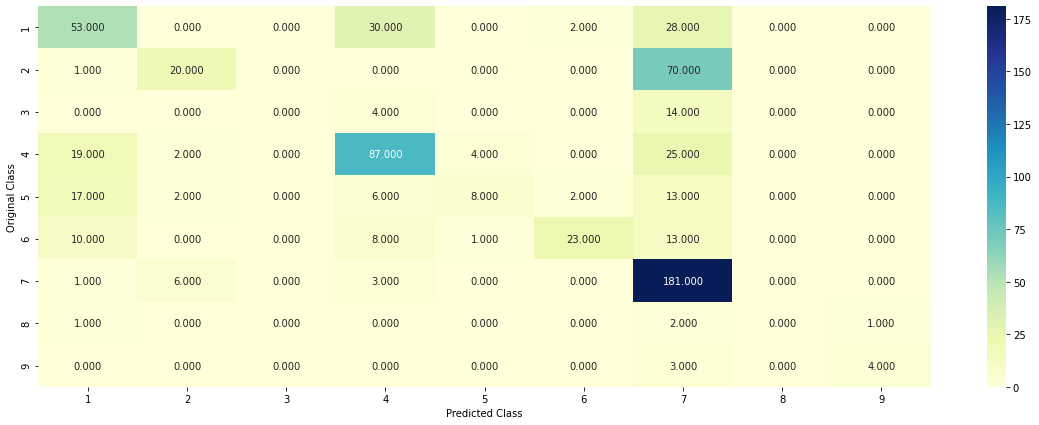

-------------------- Precision matrix (Columm Sum=1) --------------------


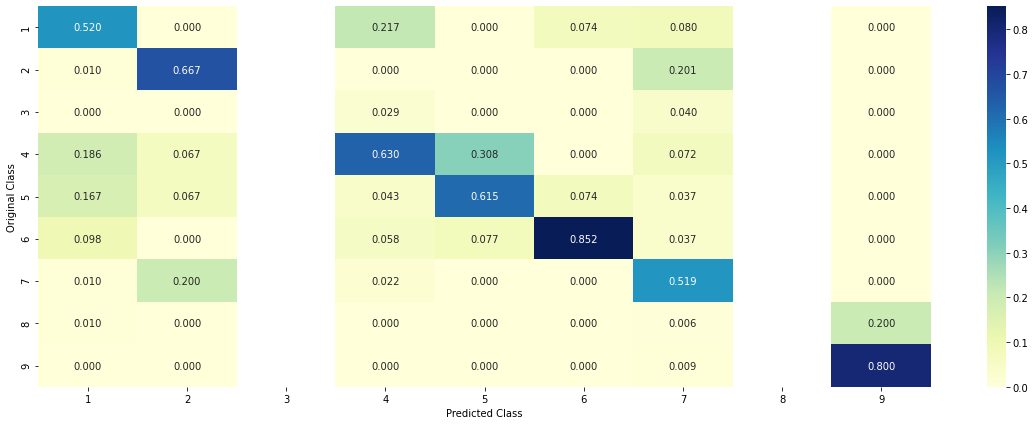

-------------------- Recall matrix (Row sum=1) --------------------


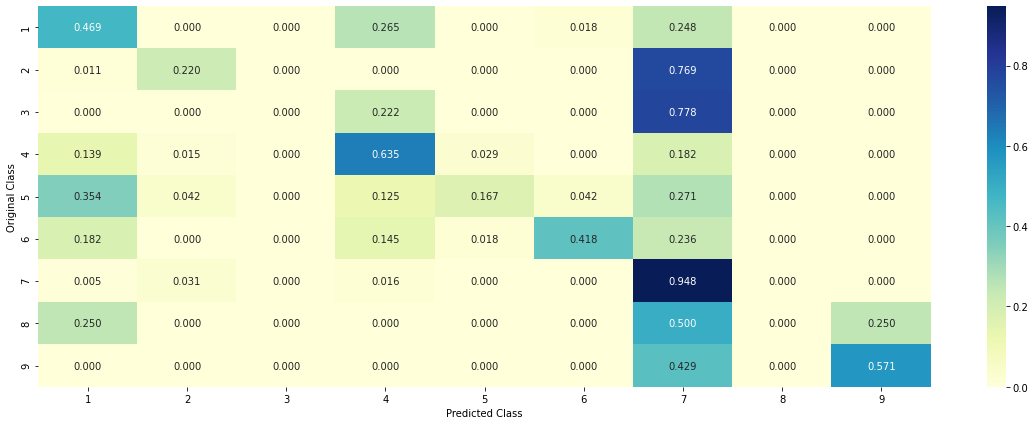

In [103]:
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_Tfidf, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_Tfidf, y_train)
sig_clf_probs = sig_clf.predict_proba(test_x_Tfidf)
# to avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss :",log_loss(y_test, sig_clf_probs))
print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(test_x_Tfidf)- y_test))/y_test.shape[0]*100)
plot_confusion_matrix(y_test, sig_clf.predict(test_x_Tfidf))

## Feature Importance, Correctly classified point

In [104]:
test_point_index = 15

no_feature = 100
predicted_cls = sig_clf.predict(test_x_Tfidf[test_point_index].reshape(1,test_x_Tfidf.shape[1]))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_Tfidf[test_point_index].reshape(1,test_x_Tfidf.shape[1])),4))
print("Actual Class :", test_y[test_point_index])
indices=np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature] 
# returns the indices of the top 100 features used in predicting the predicted_cls
print("-"*50)

get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index].lower(),test_df['Variation'].iloc[test_point_index], no_feature)


Predicted Class : 7
Predicted Class Probabilities: [[0.0848 0.0656 0.0167 0.1144 0.0482 0.0443 0.6135 0.0074 0.0052]]
Actual Class : 7
--------------------------------------------------
Out of the top  100  features  0 are present in query point


## Feature Importance, Incorrectly classified point

In [105]:
test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_Tfidf[test_point_index].reshape(1,test_x_Tfidf.shape[1]))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_Tfidf[test_point_index].reshape(1,test_x_Tfidf.shape[1])),4))
print("Actual Class :", test_y[test_point_index])
indices=np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature] 
# returns the indices of the top 100 features used in predicting the predicted_cls
print("-"*50)

get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index].lower(),test_df['Variation'].iloc[test_point_index], no_feature)


Predicted Class : 7
Predicted Class Probabilities: [[0.0443 0.0563 0.0051 0.14   0.0254 0.0223 0.7013 0.0042 0.0011]]
Actual Class : 7
--------------------------------------------------
Out of the top  100  features  0 are present in query point


#  K Nearest Neighbour Classification

##  Hyper parameter tuning 

for alpha = 5
Log Loss : 0.9648821387977597
for alpha = 11
Log Loss : 0.9557555040713768
for alpha = 15
Log Loss : 0.9874651439080491
for alpha = 21
Log Loss : 1.0366906488710779
for alpha = 31
Log Loss : 1.0486570085586648
for alpha = 41
Log Loss : 1.071663969837962
for alpha = 51
Log Loss : 1.0957675913443905
for alpha = 99
Log Loss : 1.1581360159000342


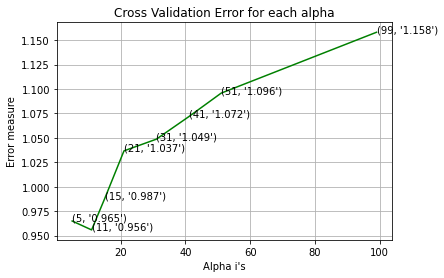

For values of best alpha =  11 The train log loss is: 0.6117534155784013
For values of best alpha =  11 The cross validation log loss is: 0.9557555040713768
For values of best alpha =  11 The test log loss is: 0.9360394243188984


In [106]:
alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_x_responseCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_responseCoding, y_train)
    sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
    cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(y_cv, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, y_train)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

## Testing the model with best hyper paramters

Log loss : 0.9360394243188984
Number of mis-classified points : 0.31626506024096385
-------------------- Confusion matrix --------------------


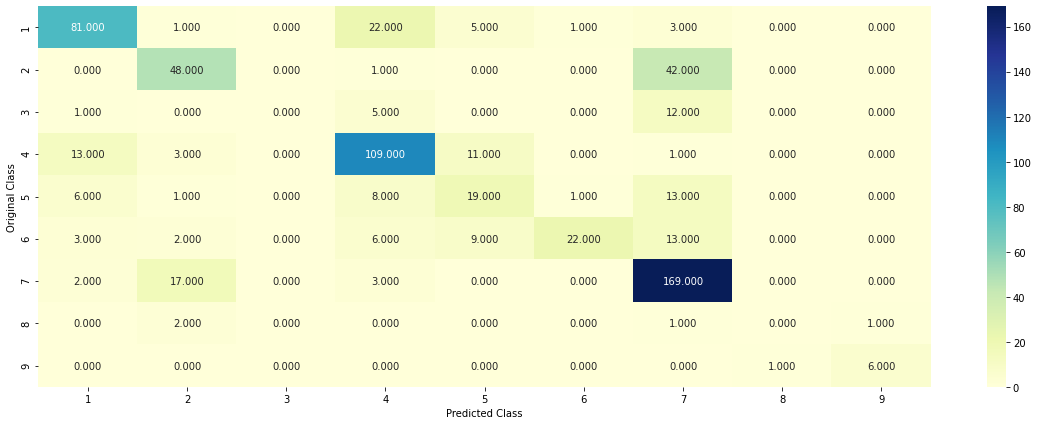

-------------------- Precision matrix (Columm Sum=1) --------------------


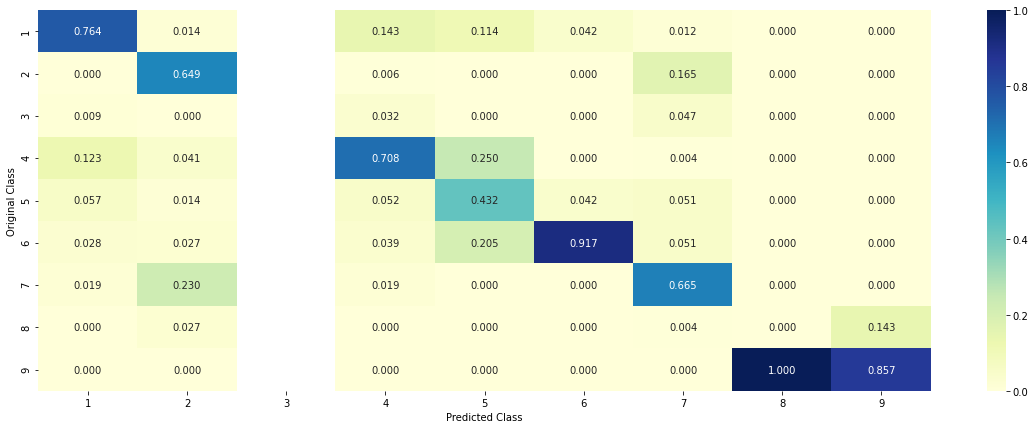

-------------------- Recall matrix (Row sum=1) --------------------


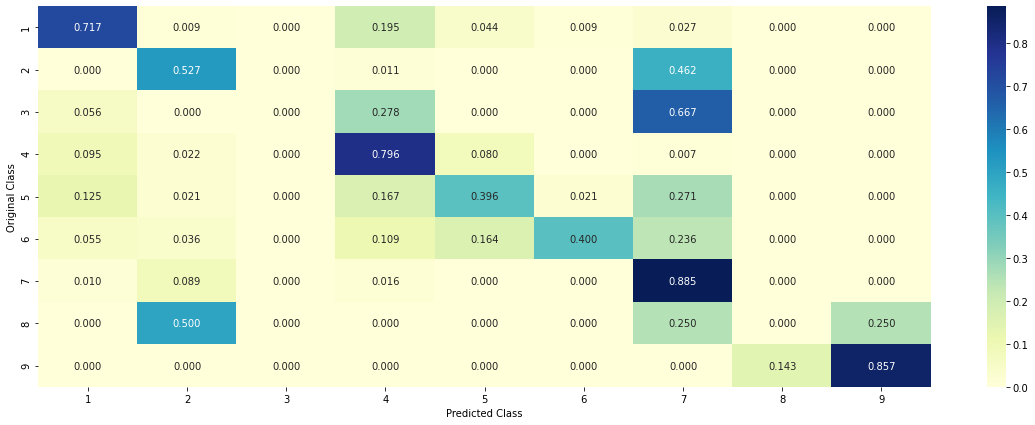

In [107]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
predict_and_plot_confusion_matrix(train_x_responseCoding, y_train, test_x_responseCoding, y_test, clf)

Since KNN is not interpretable, Hence we will not be using KNN for final modelling, eventhough it is giving us the least log -loss

## Sample Query point -1

In [108]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, y_train)

test_point_index = 1
predicted_cls = sig_clf.predict(test_x_responseCoding[0].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("The ",alpha[best_alpha]," nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 7
Actual Class : 7
The  11  nearest neighbours of the test points belongs to classes [7 7 7 7 7 7 7 7 7 7 8]
Fequency of nearest points : Counter({7: 10, 8: 1})


##  Sample Query Point-2

In [109]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, y_train)

test_point_index = 100

predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("the k value for knn is",alpha[best_alpha],"and the nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 1
Actual Class : 1
the k value for knn is 11 and the nearest neighbours of the test points belongs to classes [1 1 1 1 1 5 1 1 1 1 1]
Fequency of nearest points : Counter({1: 10, 5: 1})


It's very easy in case of KNN to get deceived by the result, we can see that the actual class 3 is not even in the NN.
Hence, we definately need feature importance that can tell us about the interpretebility.
KNN is not interpretable

#  Logistic Regression

### With Class balancing

### Hyper paramter tuning using One Hot Encoding

for alpha = 0.001
Log Loss : 1.112725690731602
for alpha = 0.01
Log Loss : 1.2274178235186355
for alpha = 0.1
Log Loss : 1.508929337367815
for alpha = 1
Log Loss : 1.7270611682172243
for alpha = 10
Log Loss : 1.75041525953864
for alpha = 100
Log Loss : 1.7529418253696745


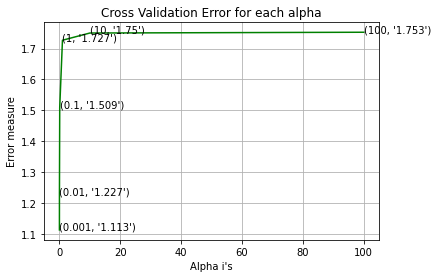

For values of best alpha =  0.001 The train log loss is: 0.52725549729891
For values of best alpha =  0.001 The cross validation log loss is: 1.112725690731602
For values of best alpha =  0.001 The test log loss is: 1.113236795754486


In [110]:
alpha = [10 ** x for x in range(-3, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, y_train)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(y_cv, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

##  Testing the model with best hyper paramters 

Log loss : 1.113236795754486
Number of mis-classified points : 0.35993975903614456
-------------------- Confusion matrix --------------------


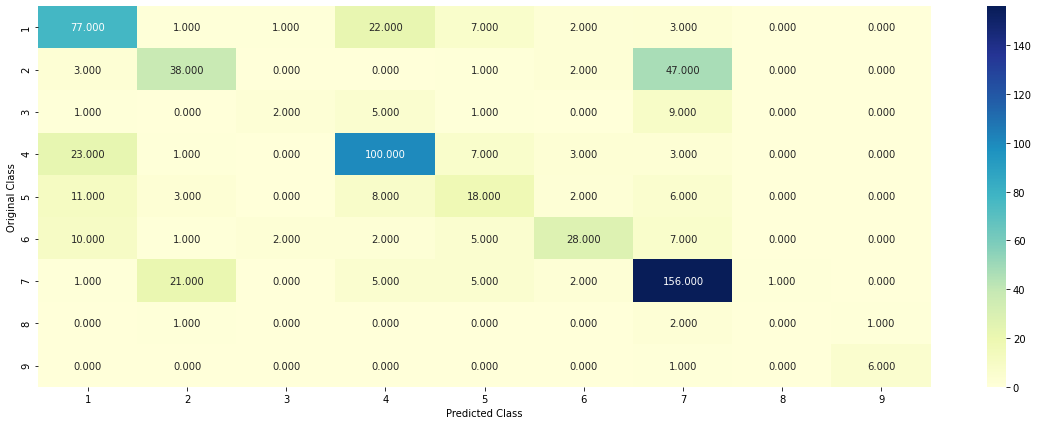

-------------------- Precision matrix (Columm Sum=1) --------------------


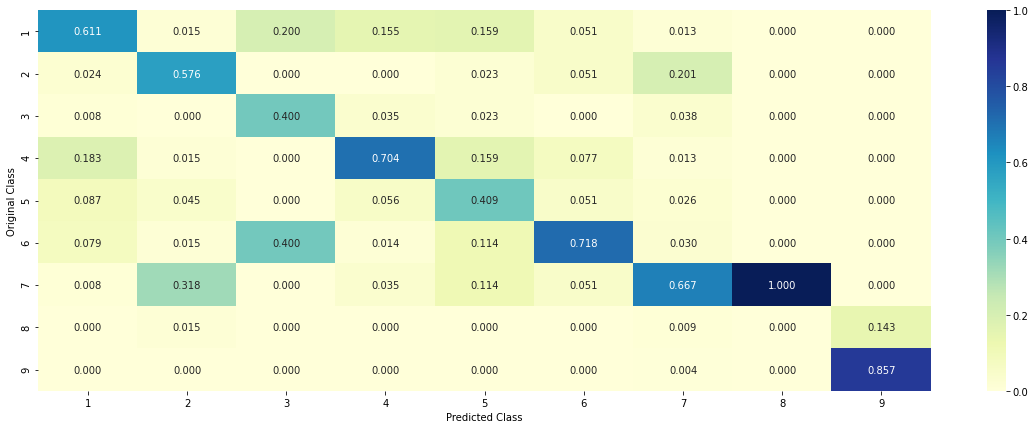

-------------------- Recall matrix (Row sum=1) --------------------


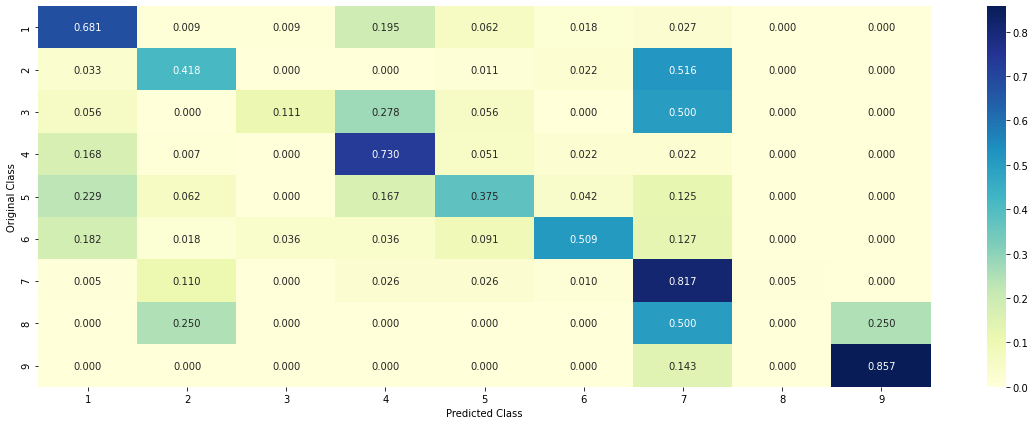

In [111]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, y_train, test_x_onehotCoding, y_test, clf)

## Feature Importance

### Correctly Classified point

In [112]:
test_point_index = 80
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Claass :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 1
Predicted Class Probabilities: [[0.5764 0.0042 0.0011 0.1646 0.2394 0.0025 0.0033 0.0065 0.002 ]]
Actual Claass : 1
--------------------------------------------------
231 Text feature [frameshift] present in test data point [True]
238 Text feature [kinase] present in test data point [True]
249 Text feature [activating] present in test data point [True]
261 Text feature [transforming] present in test data point [True]
395 Text feature [active] present in test data point [True]
Out of the top  500  features  5 are present in query point


### Incorrectly Classified point

In [113]:
test_point_index = 5
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.2558 0.088  0.0044 0.0924 0.015  0.0054 0.5161 0.0154 0.0074]]
Actual Class : 7
--------------------------------------------------
104 Text feature [constitutive] present in test data point [True]
123 Text feature [activated] present in test data point [True]
125 Text feature [constitutively] present in test data point [True]
205 Text feature [generacer] present in test data point [True]
244 Text feature [balb] present in test data point [True]
249 Text feature [downstream] present in test data point [True]
270 Text feature [function] present in test data point [True]
283 Text feature [expressing] present in test data point [True]
286 Text feature [loss] present in test data point [True]
350 Text feature [biallelic] present in test data point [True]
367 Text feature [curious] present in test data point [True]
385 Text feature [activating] present in test data point [True]
388 Text feature [serum] present in test data point [True]
4

## Hyper paramter tuning using Tfidf Encoding

for alpha = 0.001
Log Loss : 1.0019059821368226
for alpha = 0.01
Log Loss : 1.0213052432826952
for alpha = 0.1
Log Loss : 1.0760096021600627
for alpha = 1
Log Loss : 1.2605034951540024
for alpha = 10
Log Loss : 1.4053393824287628
for alpha = 100
Log Loss : 1.5645103456393024


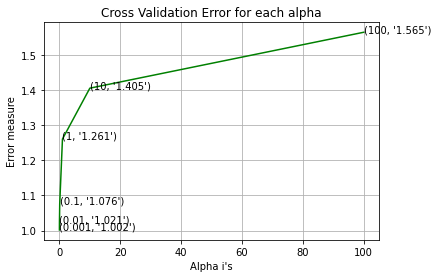

For values of best alpha =  0.001 The train log loss is: 0.4889074852681008
For values of best alpha =  0.001 The cross validation log loss is: 1.0019059821368226
For values of best alpha =  0.001 The test log loss is: 1.002759896251061


In [114]:
alpha = [10 ** x for x in range(-3, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_Tfidf, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_Tfidf, y_train)
    sig_clf_probs = sig_clf.predict_proba(cv_x_Tfidf)
    cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(y_cv, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_Tfidf, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_Tfidf, y_train)

predict_y = sig_clf.predict_proba(train_x_Tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_Tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_Tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

## Testing the model with best hyper paramters

Log loss : 1.002759896251061
Number of mis-classified points : 0.3569277108433735
-------------------- Confusion matrix --------------------


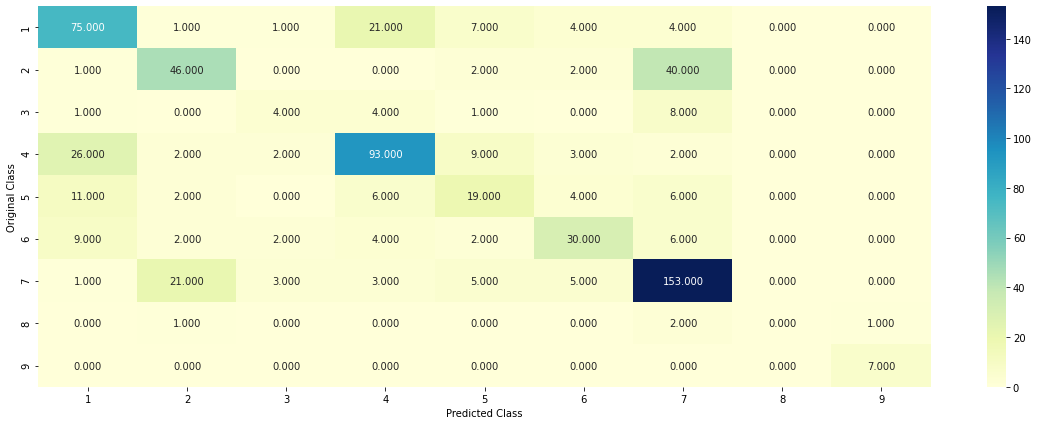

-------------------- Precision matrix (Columm Sum=1) --------------------


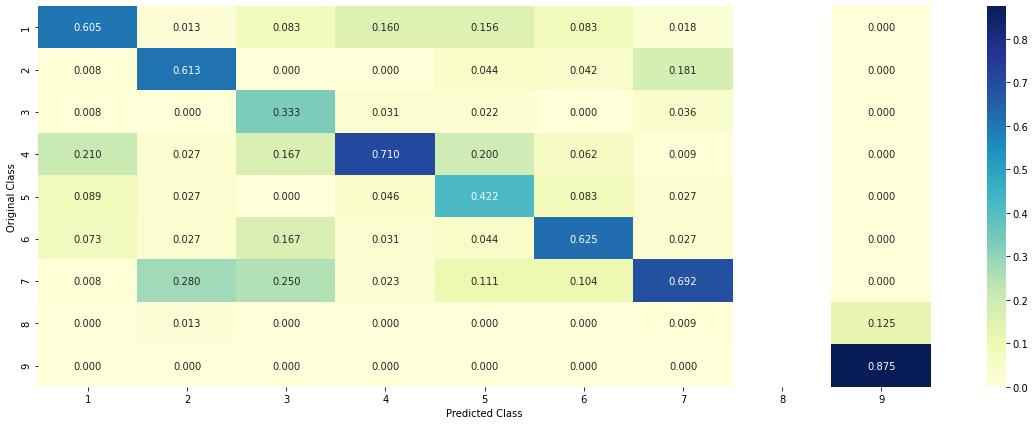

-------------------- Recall matrix (Row sum=1) --------------------


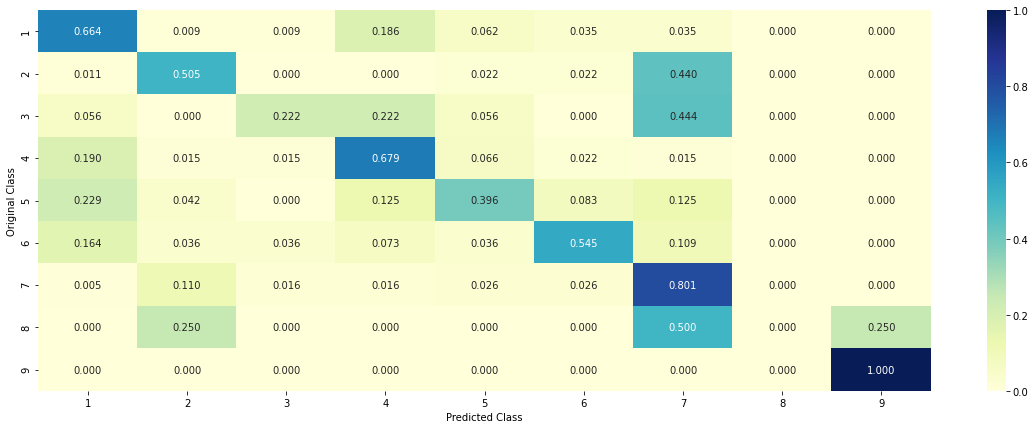

In [115]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_Tfidf, y_train, test_x_Tfidf, y_test, clf)

## Feature Importance

## Correctly Classified point

In [116]:
test_point_index = 80
no_feature = 500
predicted_cls = sig_clf.predict(test_x_Tfidf[test_point_index].reshape(1,test_x_Tfidf.shape[1]))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_Tfidf[test_point_index].reshape(1,test_x_Tfidf.shape[1])),4))
print("Actual Claass :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 1
Predicted Class Probabilities: [[0.5862 0.0071 0.0052 0.0552 0.3202 0.0156 0.0036 0.0037 0.0032]]
Actual Claass : 1
--------------------------------------------------
224 Text feature [frameshift] present in test data point [True]
270 Text feature [deletion] present in test data point [True]
311 Text feature [kinase] present in test data point [True]
418 Text feature [interfaces] present in test data point [True]
447 Text feature [table1] present in test data point [True]
462 Text feature [stop] present in test data point [True]
Out of the top  500  features  6 are present in query point


## Incorrectly Classified point

In [117]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_Tfidf,y_train)
test_point_index = 22
no_feature = 500
predicted_cls = sig_clf.predict(test_x_Tfidf[test_point_index].reshape(1,test_x_Tfidf.shape[1]))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_Tfidf[test_point_index].reshape(1,test_x_Tfidf.shape[1])),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 2
Predicted Class Probabilities: [[0.0176 0.5803 0.0065 0.005  0.101  0.0086 0.2717 0.0058 0.0037]]
Actual Class : 2
--------------------------------------------------
89 Text feature [chronic] present in test data point [True]
158 Text feature [t790m] present in test data point [True]
180 Text feature [treatment] present in test data point [True]
227 Text feature [therapy] present in test data point [True]
229 Text feature [achieved] present in test data point [True]
274 Text feature [ongoing] present in test data point [True]
286 Text feature [advanced] present in test data point [True]
306 Text feature [d761y] present in test data point [True]
319 Text feature [promising] present in test data point [True]
327 Text feature [nested] present in test data point [True]
333 Text feature [months] present in test data point [True]
337 Text feature [demographic] present in test data point [True]
386 Text feature [computed] present in test data point [True]
387 Text feature 

## Without Class balancing

### Hyper paramter tuning using One Hot Encoding

for alpha = 0.001
Log Loss : 1.1148180937314802
for alpha = 0.01
Log Loss : 1.2218607560452515
for alpha = 0.1
Log Loss : 1.4470500630260148
for alpha = 1
Log Loss : 1.6395507247897505


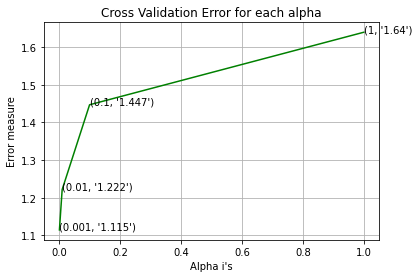

For values of best alpha =  0.001 The train log loss is: 0.5213085611634051
For values of best alpha =  0.001 The cross validation log loss is: 1.1148180937314802
For values of best alpha =  0.001 The test log loss is: 1.1221076280049431


In [118]:
alpha = [10 ** x for x in range(-3, 1)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, y_train)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(y_cv, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

## Testing model with best hyper parameters

Log loss : 1.1221076280049431
Number of mis-classified points : 0.3569277108433735
-------------------- Confusion matrix --------------------


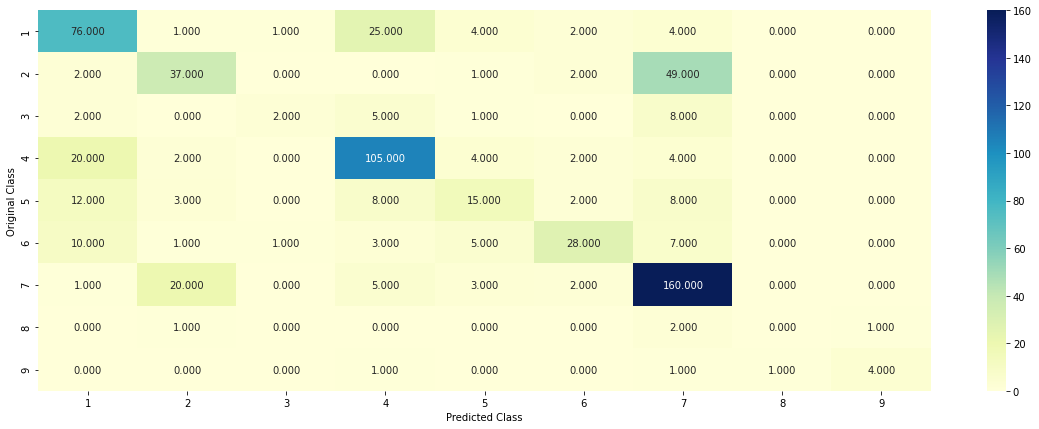

-------------------- Precision matrix (Columm Sum=1) --------------------


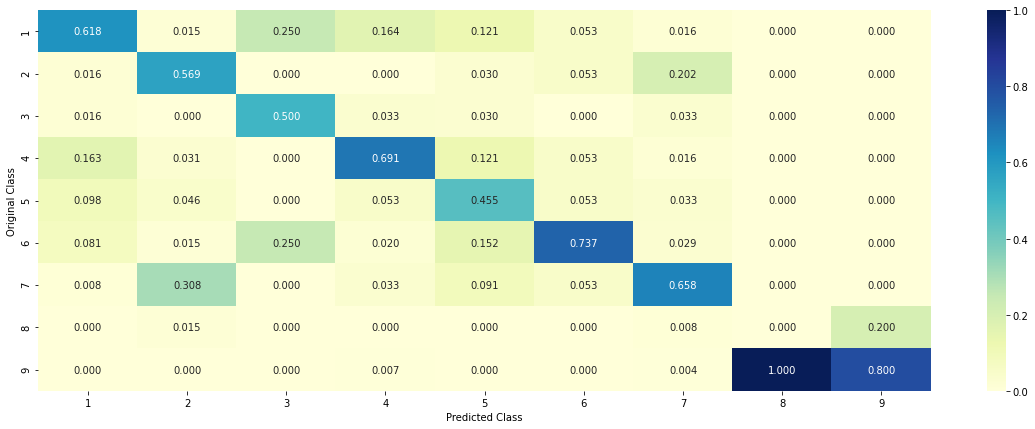

-------------------- Recall matrix (Row sum=1) --------------------


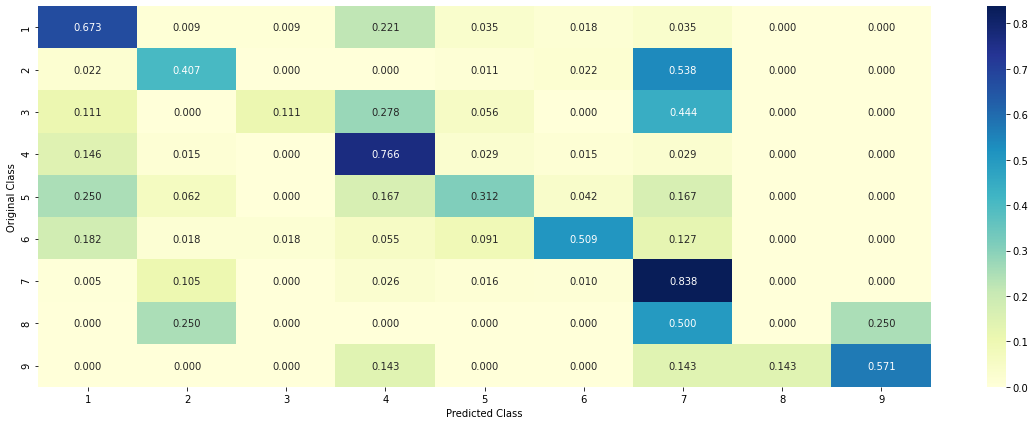

In [119]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, y_train, test_x_onehotCoding, y_test, clf)

## Feature Importance, Correctly Classified point

In [120]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,y_train)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0368 0.1195 0.0068 0.1422 0.0174 0.012  0.6528 0.0093 0.0032]]
Actual Class : 7
--------------------------------------------------
229 Text feature [constitutive] present in test data point [True]
230 Text feature [constitutively] present in test data point [True]
274 Text feature [nonsense] present in test data point [True]
275 Text feature [activated] present in test data point [True]
349 Text feature [expressing] present in test data point [True]
374 Text feature [missense] present in test data point [True]
394 Text feature [activating] present in test data point [True]
429 Text feature [downstream] present in test data point [True]
439 Text feature [frameshift] present in test data point [True]
483 Text feature [mitogen] present in test data point [True]
Out of the top  500  features  10 are present in query point


##   Incorrectly Classified point

In [121]:
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 1
Predicted Class Probabilities: [[0.8141 0.0257 0.0042 0.0218 0.0938 0.0073 0.0236 0.007  0.0025]]
Actual Class : 1
--------------------------------------------------
287 Text feature [frameshift] present in test data point [True]
317 Text feature [657del5] present in test data point [True]
463 Text feature [bethesda] present in test data point [True]
Out of the top  500  features  3 are present in query point


## Hyper paramter tuning using Tf-idf

for alpha = 0.001
Log Loss : 0.9941256651025976
for alpha = 0.01
Log Loss : 1.0050197374817114
for alpha = 0.1
Log Loss : 1.0655214277020466
for alpha = 1
Log Loss : 1.2143886796141654
for alpha = 10
Log Loss : 1.3952222682175057
for alpha = 100
Log Loss : 1.5794643615462338


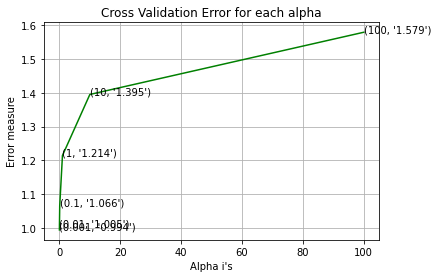

For values of best alpha =  0.001 The train log loss is: 0.4831046088282266
For values of best alpha =  0.001 The cross validation log loss is: 0.9941256651025976
For values of best alpha =  0.001 The test log loss is: 0.9981307860946543


In [122]:
alpha = [10 ** x for x in range(-3, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_Tfidf, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_Tfidf, y_train)
    sig_clf_probs = sig_clf.predict_proba(cv_x_Tfidf)
    cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(y_cv, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_Tfidf, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_Tfidf, y_train)

predict_y = sig_clf.predict_proba(train_x_Tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_Tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_Tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

## Testing model with best hyper parameters

Log loss : 0.9981307860946543
Number of mis-classified points : 0.35993975903614456
-------------------- Confusion matrix --------------------


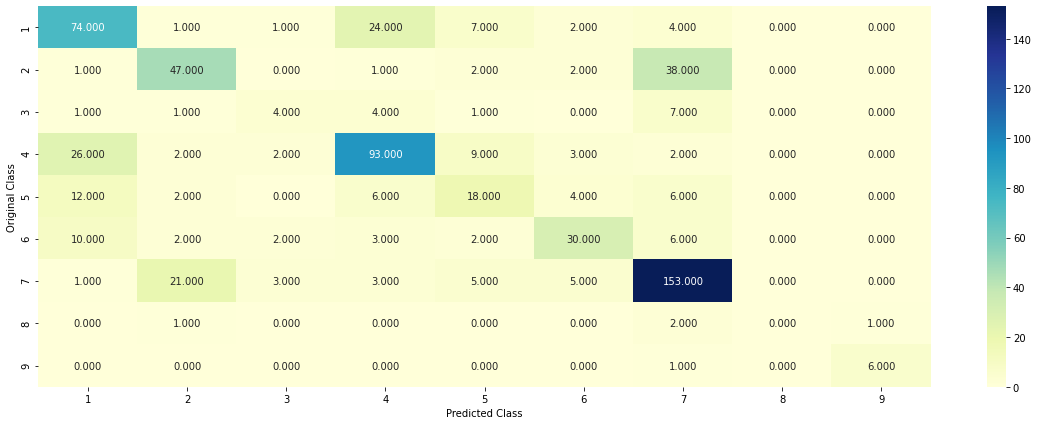

-------------------- Precision matrix (Columm Sum=1) --------------------


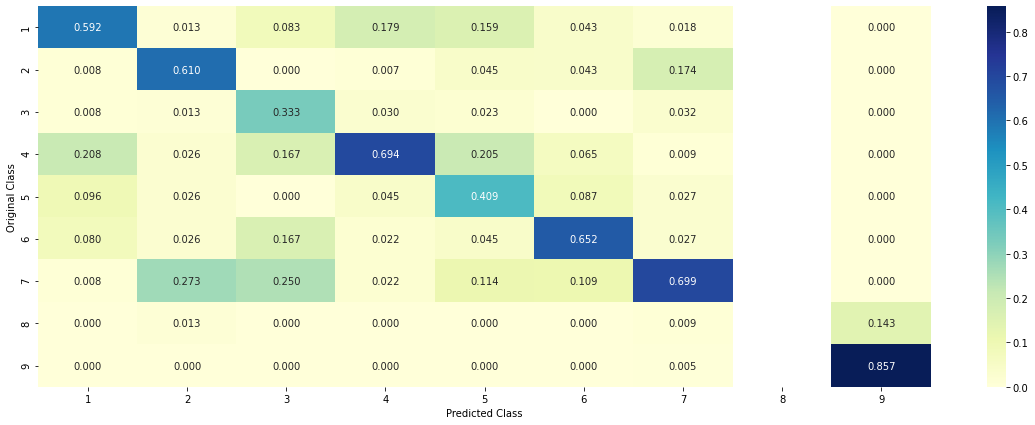

-------------------- Recall matrix (Row sum=1) --------------------


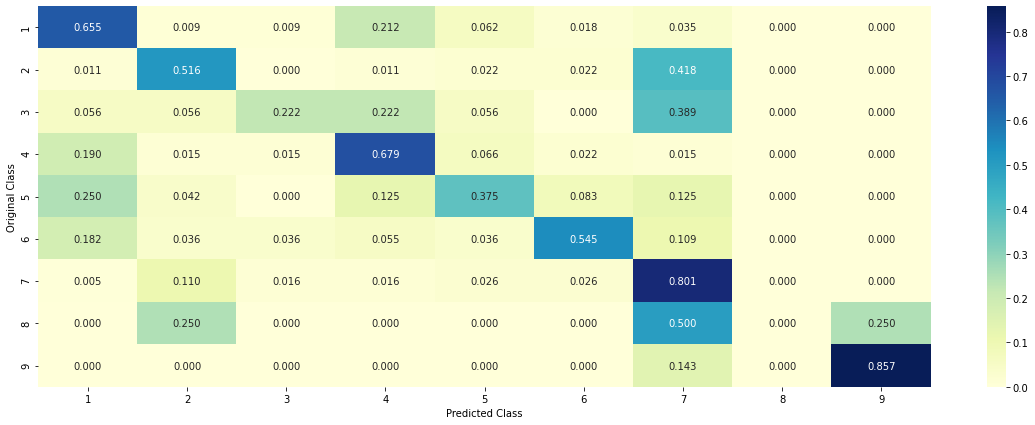

In [123]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_Tfidf, y_train, test_x_Tfidf, y_test, clf)

## Feature Importance, Correctly Classified point 

In [124]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_Tfidf,y_train)
test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_Tfidf[test_point_index].reshape(1,test_x_Tfidf.shape[1]))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_Tfidf[test_point_index].reshape(1,test_x_Tfidf.shape[1])),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0428 0.136  0.0144 0.1501 0.0249 0.0199 0.5951 0.012  0.0049]]
Actual Class : 7
--------------------------------------------------
69 Text feature [activated] present in test data point [True]
70 Text feature [constitutive] present in test data point [True]
79 Text feature [constitutively] present in test data point [True]
Out of the top  100  features  3 are present in query point


## Incorrectly Classified point

In [125]:
test_point_index = 23
no_feature = 100
predicted_cls = sig_clf.predict(test_x_Tfidf[test_point_index].reshape(1,test_x_Tfidf.shape[1]))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_Tfidf[test_point_index].reshape(1,test_x_Tfidf.shape[1])),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[0.0483 0.0043 0.0068 0.5385 0.3876 0.0074 0.0014 0.0038 0.0017]]
Actual Class : 5
--------------------------------------------------
Out of the top  100  features  0 are present in query point


# Linear Support Vector Machines

## Hyper paramter tuning using One Hot Encoding

for C = 1e-05
Log Loss : 1.3204070569063842
for C = 0.0001
Log Loss : 1.2173471879224103
for C = 0.001
Log Loss : 1.1132559248433698
for C = 0.01
Log Loss : 1.1431682993923868
for C = 0.1
Log Loss : 1.4201368677170803
for C = 1
Log Loss : 1.7461810916185774
for C = 10
Log Loss : 1.7533836236229674
for C = 100
Log Loss : 1.7533847120912571


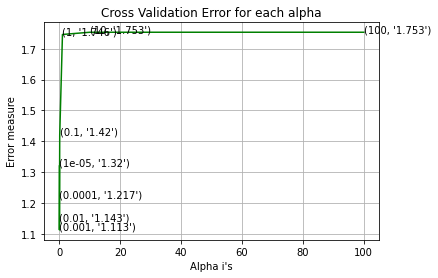

For values of best alpha =  0.001 The train log loss is: 0.5300290297006974
For values of best alpha =  0.001 The cross validation log loss is: 1.1132559248433698
For values of best alpha =  0.001 The test log loss is: 1.1778514695476443


In [126]:
alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
#     clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, y_train)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(y_cv, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
# clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

## Testing model with best hyper parameters

Log loss : 1.1778514695476443
Number of mis-classified points : 0.3493975903614458
-------------------- Confusion matrix --------------------


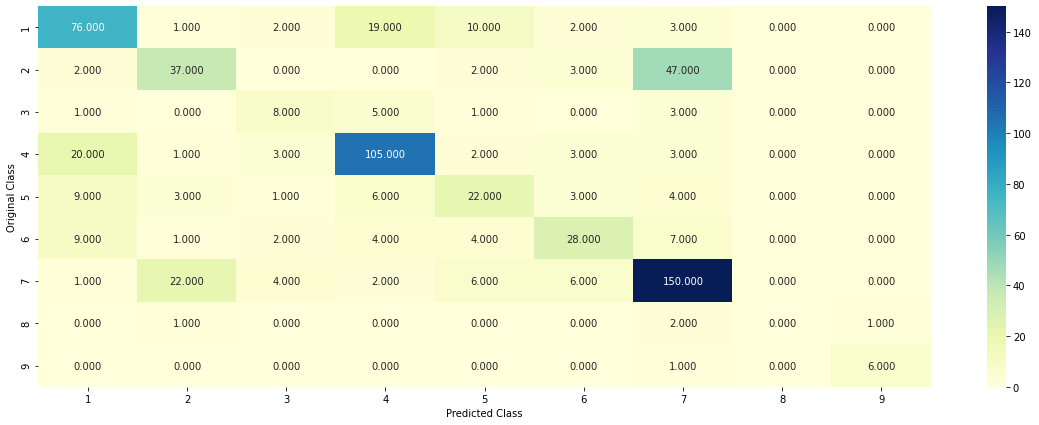

-------------------- Precision matrix (Columm Sum=1) --------------------


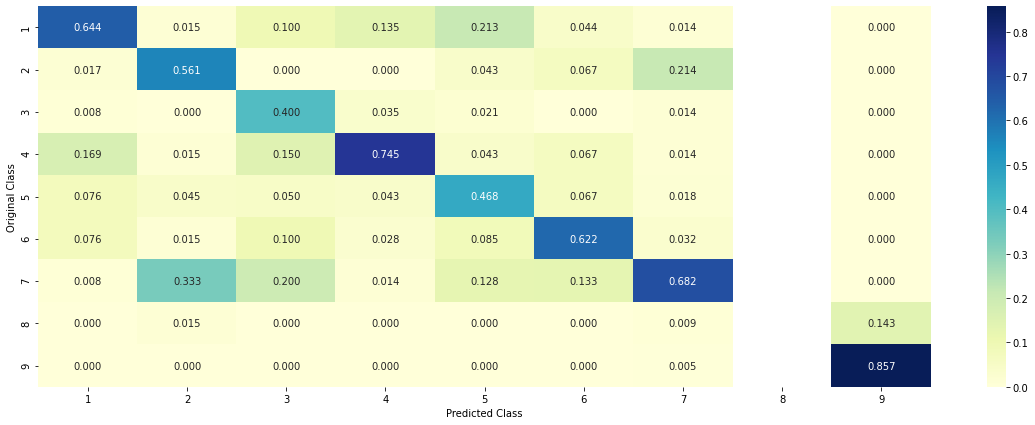

-------------------- Recall matrix (Row sum=1) --------------------


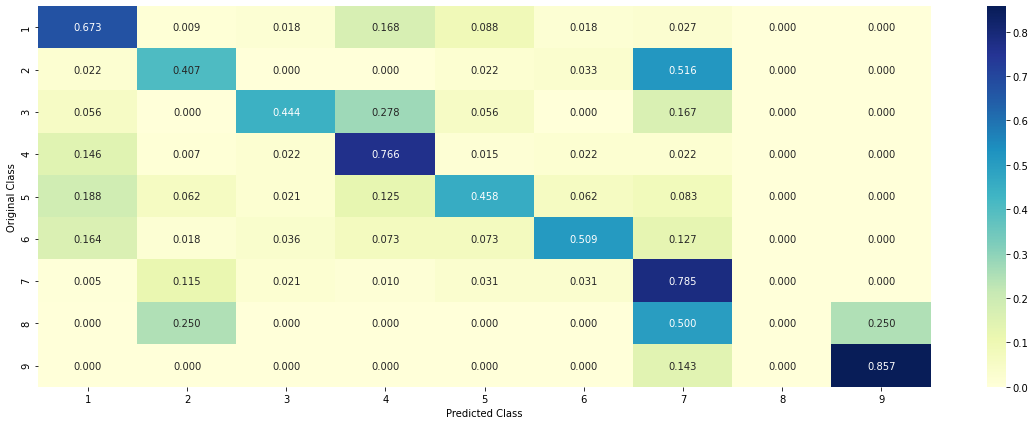

In [127]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42,class_weight='balanced')
predict_and_plot_confusion_matrix(train_x_onehotCoding, y_train,test_x_onehotCoding,y_test, clf)

## Feature Importance

###  For Correctly classified point

In [128]:
test_point_index = 111
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 6
Predicted Class Probabilities: [[0.0455 0.0321 0.0092 0.0213 0.0173 0.8268 0.0378 0.0046 0.0054]]
Actual Class : 6
--------------------------------------------------
Out of the top  500  features  0 are present in query point


### For Incorrectly classified point
 

In [129]:
test_point_index = 11

no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 2
Predicted Class Probabilities: [[2.040e-02 8.824e-01 4.000e-04 6.700e-03 1.400e-03 6.000e-04 3.200e-03
  8.200e-02 2.800e-03]]
Actual Class : 7
--------------------------------------------------
479 Text feature [bak1] present in test data point [True]
Out of the top  500  features  1 are present in query point


## Hyper paramter tuning using Tf-idf Encoding

for C = 1e-05
Log Loss : 1.1700092035668446
for C = 0.0001
Log Loss : 1.1340875238873944
for C = 0.001
Log Loss : 1.0804706608622414
for C = 0.01
Log Loss : 1.1302651921726987
for C = 0.1
Log Loss : 1.160037113555606
for C = 1
Log Loss : 1.1525074957273995
for C = 10
Log Loss : 1.2085958033658997
for C = 100
Log Loss : 1.6295717435760984


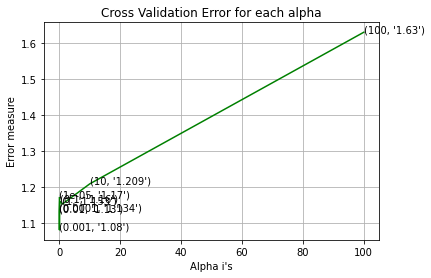

For values of best alpha =  0.001 The train log loss is: 0.5207667033233411
For values of best alpha =  0.001 The cross validation log loss is: 1.0804706608622414
For values of best alpha =  0.001 The test log loss is: 1.1084571006660937


In [130]:
alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
#     clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_Tfidf, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_Tfidf, y_train)
    sig_clf_probs = sig_clf.predict_proba(cv_x_Tfidf)
    cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(y_cv, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
# clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_Tfidf, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_Tfidf, y_train)

predict_y = sig_clf.predict_proba(train_x_Tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_Tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_Tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

## Testing model with best hyper parameters

Log loss : 1.1084571006660937
Number of mis-classified points : 0.3509036144578313
-------------------- Confusion matrix --------------------


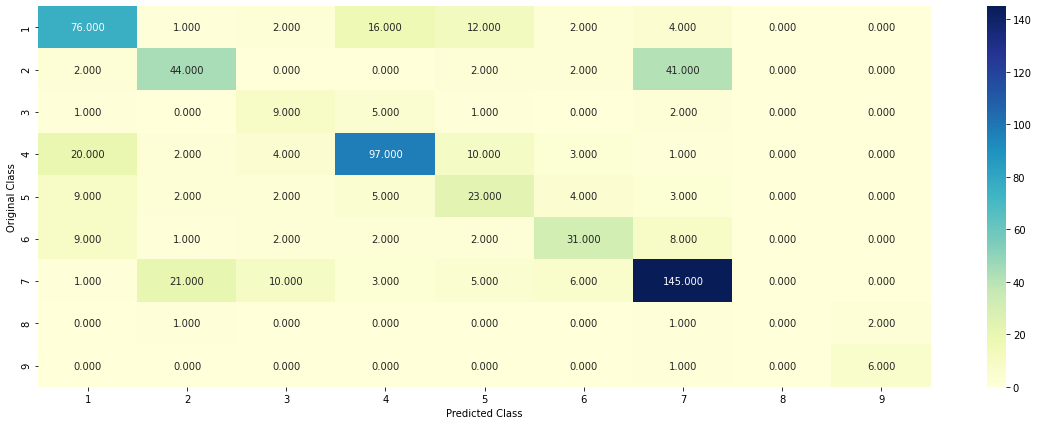

-------------------- Precision matrix (Columm Sum=1) --------------------


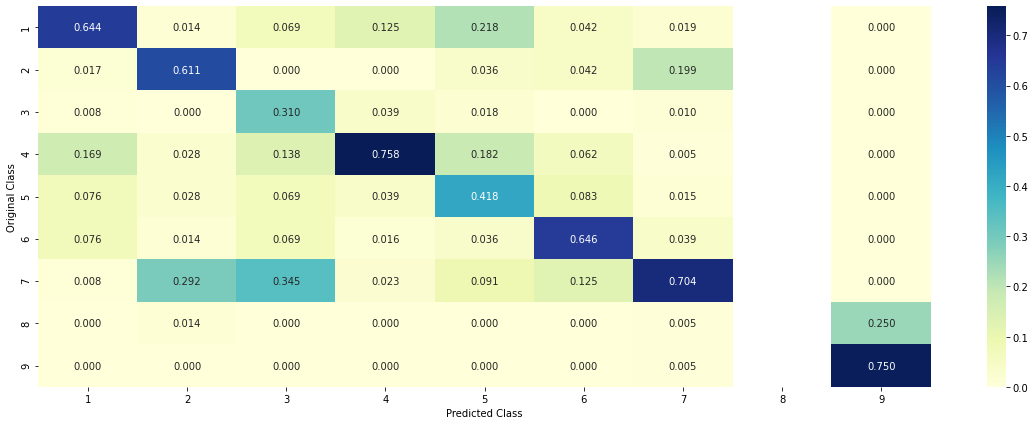

-------------------- Recall matrix (Row sum=1) --------------------


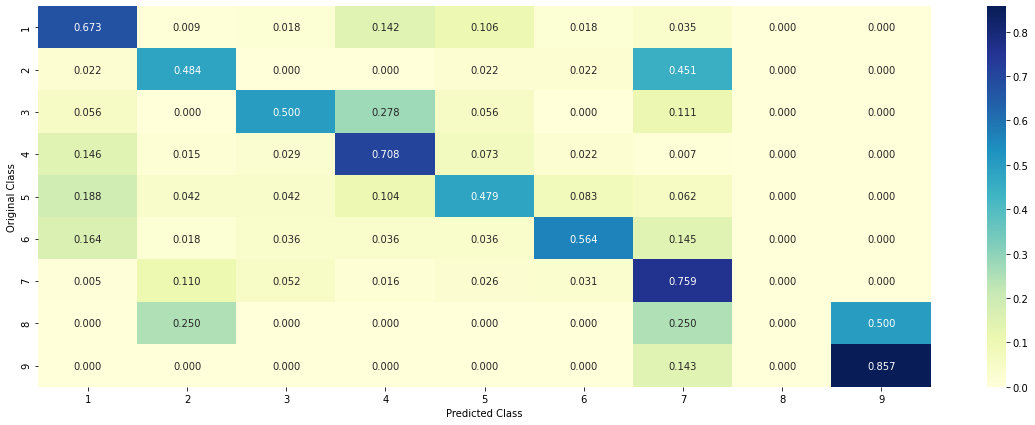

In [131]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42,class_weight='balanced')
predict_and_plot_confusion_matrix(train_x_Tfidf, y_train,test_x_Tfidf,y_test, clf)

# Feature Importance

## For Correctly classified point

In [132]:
test_point_index = 11

no_feature = 500
predicted_cls = sig_clf.predict(test_x_Tfidf[test_point_index].reshape(1,test_x_Tfidf.shape[1]))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_Tfidf[test_point_index].reshape(1,test_x_Tfidf.shape[1])),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 2
Predicted Class Probabilities: [[0.0176 0.7698 0.0287 0.0185 0.0206 0.0067 0.0225 0.1068 0.0089]]
Actual Class : 7
--------------------------------------------------
252 Text feature [balanced] present in test data point [True]
255 Text feature [paradigm] present in test data point [True]
307 Text feature [parts] present in test data point [True]
323 Text feature [ets] present in test data point [True]
362 Text feature [sealing] present in test data point [True]
364 Text feature [bak1] present in test data point [True]
454 Text feature [copper] present in test data point [True]
Out of the top  500  features  7 are present in query point


## For Incorrectly classified point

In [133]:
test_point_index = 111
no_feature = 500
predicted_cls = sig_clf.predict(test_x_Tfidf[test_point_index].reshape(1,test_x_Tfidf.shape[1]))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_Tfidf[test_point_index].reshape(1,test_x_Tfidf.shape[1])),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 6
Predicted Class Probabilities: [[0.0442 0.0292 0.0138 0.0155 0.0346 0.8202 0.0345 0.0034 0.0046]]
Actual Class : 6
--------------------------------------------------
Out of the top  500  features  0 are present in query point


# Random Forest Classifier

## Hyper paramter tuning with OneHot Encoding 

In [134]:
alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(class_weight='balanced',n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_onehotCoding, y_train)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_onehotCoding, y_train)
        sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
        cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(y_cv, sig_clf_probs)) 

'''fig, ax = plt.subplots()
features = np.dot(np.array(alpha)[:,None],np.array(max_depth)[None]).ravel()
ax.plot(features, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[int(i/2)],max_depth[int(i%2)],str(txt)), (features[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()
'''

best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(class_weight='balanced',n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for n_estimators = 100 and max depth =  5
Log Loss : 1.326907624723227
for n_estimators = 100 and max depth =  10
Log Loss : 1.246577800967577
for n_estimators = 200 and max depth =  5
Log Loss : 1.2987054579713229
for n_estimators = 200 and max depth =  10
Log Loss : 1.22678358455241
for n_estimators = 500 and max depth =  5
Log Loss : 1.2744644755017742
for n_estimators = 500 and max depth =  10
Log Loss : 1.2157809944912832
for n_estimators = 1000 and max depth =  5
Log Loss : 1.262941839597112
for n_estimators = 1000 and max depth =  10
Log Loss : 1.2125799936253896
for n_estimators = 2000 and max depth =  5
Log Loss : 1.255271461387089
for n_estimators = 2000 and max depth =  10
Log Loss : 1.2099821221754348
For values of best estimator =  2000 The train log loss is: 0.7873361071579597
For values of best estimator =  2000 The cross validation log loss is: 1.209982122175435
For values of best estimator =  2000 The test log loss is: 1.2064678904717816


## Testing model with best hyper parameters 

Log loss : 1.2064678904717816
Number of mis-classified points : 0.37349397590361444
-------------------- Confusion matrix --------------------


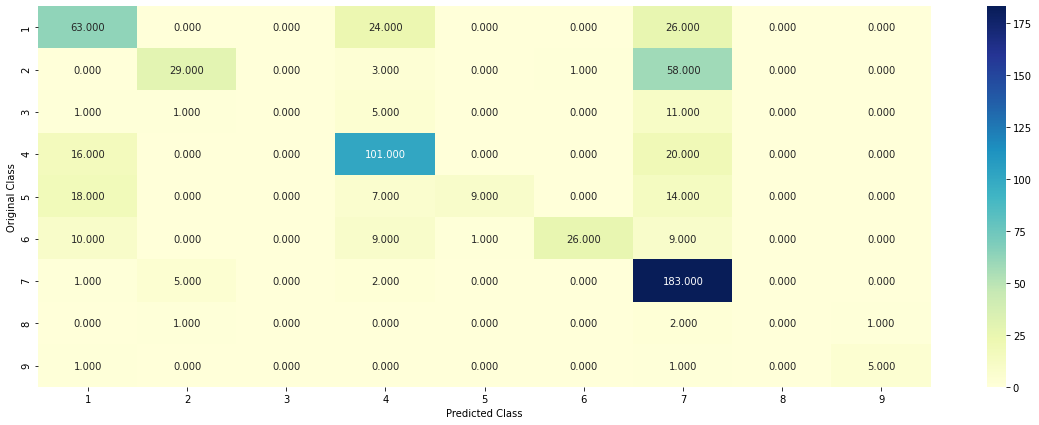

-------------------- Precision matrix (Columm Sum=1) --------------------


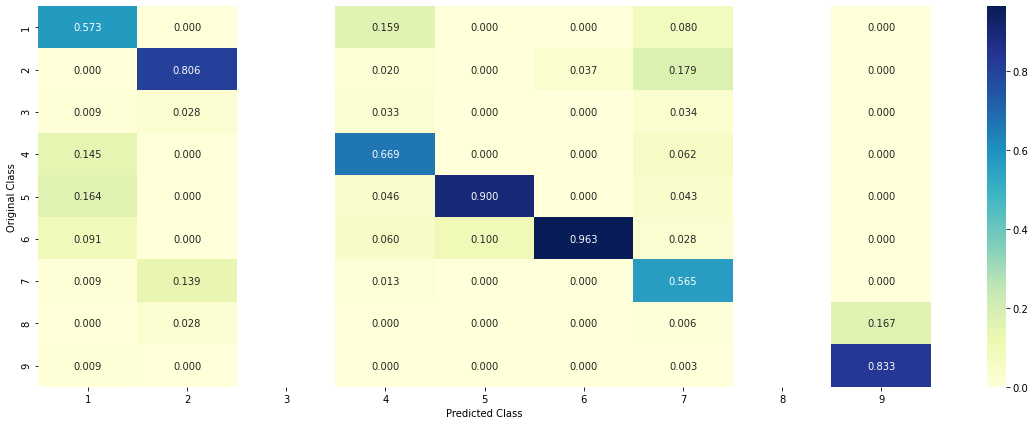

-------------------- Recall matrix (Row sum=1) --------------------


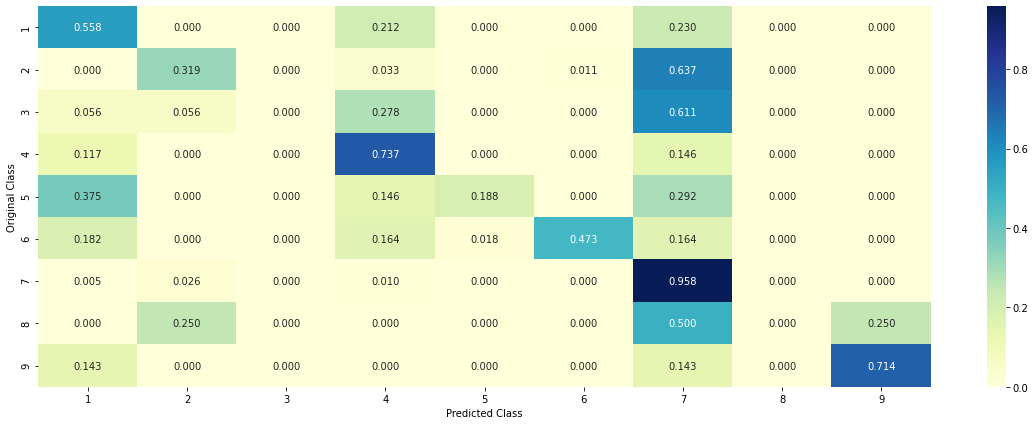

In [135]:
clf = RandomForestClassifier(class_weight='balanced',n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(train_x_onehotCoding, y_train,test_x_onehotCoding,y_test, clf)

##  Feature Importance

### Correctly Classified point
 

In [136]:
test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:no_feature], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.1201 0.0884 0.0209 0.2217 0.0482 0.0425 0.4356 0.0157 0.0068]]
Actual Class : 7
--------------------------------------------------
0 Text feature [kinase] present in test data point [True]
9 Text feature [activating] present in test data point [True]
10 Text feature [expression] present in test data point [True]
13 Text feature [cells] present in test data point [True]
14 Text feature [phosphorylation] present in test data point [True]
17 Text feature [splicing] present in test data point [True]
22 Text feature [treatment] present in test data point [True]
23 Text feature [functional] present in test data point [True]
52 Text feature [patients] present in test data point [True]
58 Text feature [cell] present in test data point [True]
59 Text feature [assays] present in test data point [True]
82 Text feature [missense] present in test data point [True]
91 Text feature [mutant] present in test data point [True]
92 Text feature [resul

##  Incorrectly Classified point

In [137]:
test_point_index = 100
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actuall Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:no_feature], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 1
Predicted Class Probabilities: [[0.5809 0.0262 0.017  0.1509 0.0741 0.0496 0.0895 0.006  0.0058]]
Actuall Class : 1
--------------------------------------------------
4 Text feature [variants] present in test data point [True]
5 Text feature [brca1] present in test data point [True]
8 Text feature [deleterious] present in test data point [True]
10 Text feature [expression] present in test data point [True]
13 Text feature [cells] present in test data point [True]
23 Text feature [functional] present in test data point [True]
27 Text feature [variant] present in test data point [True]
46 Text feature [brca2] present in test data point [True]
52 Text feature [patients] present in test data point [True]
58 Text feature [cell] present in test data point [True]
59 Text feature [assays] present in test data point [True]
82 Text feature [missense] present in test data point [True]
92 Text feature [results] present in test data point [True]
Out of the top  100  features  13

## Hyper paramter tuning with Tf-idf Encoding 

In [138]:
alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(class_weight='balanced',n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_Tfidf, y_train)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_Tfidf, y_train)
        sig_clf_probs = sig_clf.predict_proba(cv_x_Tfidf)
        cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(y_cv, sig_clf_probs)) 

'''fig, ax = plt.subplots()
features = np.dot(np.array(alpha)[:,None],np.array(max_depth)[None]).ravel()
ax.plot(features, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[int(i/2)],max_depth[int(i%2)],str(txt)), (features[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()
'''

best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(class_weight='balanced',n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_Tfidf, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_Tfidf, y_train)

predict_y = sig_clf.predict_proba(train_x_Tfidf)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_Tfidf)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_Tfidf)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for n_estimators = 100 and max depth =  5
Log Loss : 1.3239246684053378
for n_estimators = 100 and max depth =  10
Log Loss : 1.2188769732916962
for n_estimators = 200 and max depth =  5
Log Loss : 1.2829282705460023
for n_estimators = 200 and max depth =  10
Log Loss : 1.1947387959244145
for n_estimators = 500 and max depth =  5
Log Loss : 1.255476181494366
for n_estimators = 500 and max depth =  10
Log Loss : 1.1799796887824217
for n_estimators = 1000 and max depth =  5
Log Loss : 1.248123952370207
for n_estimators = 1000 and max depth =  10
Log Loss : 1.1733916922621772
for n_estimators = 2000 and max depth =  5
Log Loss : 1.2444020787859897
for n_estimators = 2000 and max depth =  10
Log Loss : 1.172333670096848
For values of best estimator =  2000 The train log loss is: 0.6920669172953728
For values of best estimator =  2000 The cross validation log loss is: 1.172333670096848
For values of best estimator =  2000 The test log loss is: 1.1468817424677622


## Testing model with best hyper parameters

Log loss : 1.1468817424677622
Number of mis-classified points : 0.3810240963855422
-------------------- Confusion matrix --------------------


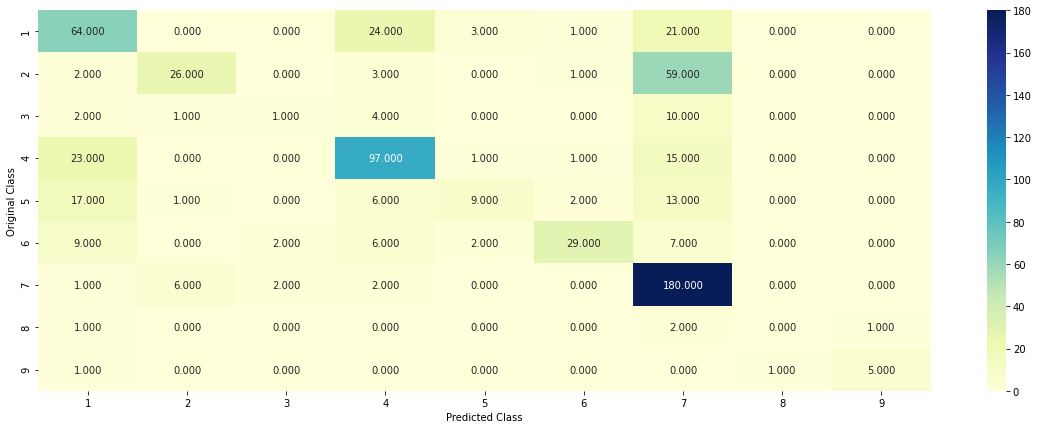

-------------------- Precision matrix (Columm Sum=1) --------------------


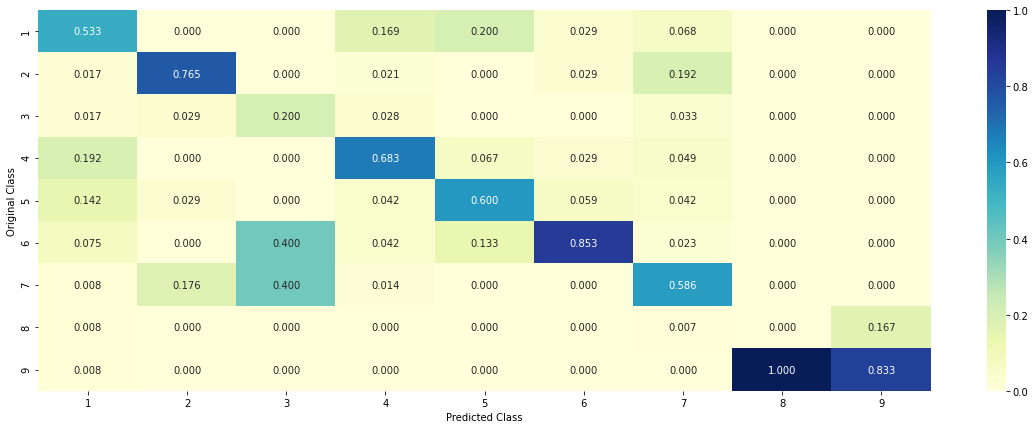

-------------------- Recall matrix (Row sum=1) --------------------


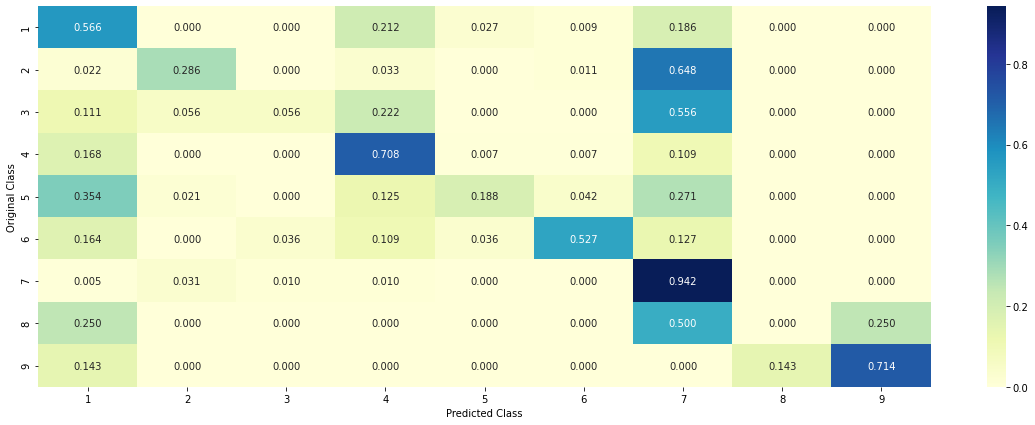

In [139]:
clf = RandomForestClassifier(class_weight='balanced',n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(train_x_Tfidf, y_train,test_x_Tfidf,y_test, clf)

# Feature Importance 

In [140]:
test_point_index = 20
no_feature = 100
predicted_cls = sig_clf.predict(test_x_Tfidf[test_point_index].reshape(1,test_x_Tfidf.shape[1]))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_Tfidf[test_point_index].reshape(1,test_x_Tfidf.shape[1])),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:no_feature], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[0.211  0.0136 0.0122 0.5953 0.0954 0.042  0.0199 0.0054 0.0052]]
Actual Class : 1
--------------------------------------------------
5 Text feature [treatment] present in test data point [True]
22 Text feature [variant] present in test data point [True]
33 Text feature [assay] present in test data point [True]
45 Text feature [functional] present in test data point [True]
46 Text feature [assays] present in test data point [True]
49 Text feature [histone] present in test data point [True]
50 Text feature [expected] present in test data point [True]
64 Text feature [use] present in test data point [True]
66 Text feature [function] present in test data point [True]
69 Text feature [inhibitor] present in test data point [True]
71 Text feature [large] present in test data point [True]
72 Text feature [rna] present in test data point [True]
81 Text feature [expression] present in test data point [True]
88 Text feature [subtle] present in 

## Incorrectly Classified point 

In [141]:
test_point_index = 11
no_feature = 100
predicted_cls = sig_clf.predict(train_x_Tfidf[test_point_index].reshape(1,test_x_Tfidf.shape[1]))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(train_x_Tfidf[test_point_index].reshape(1,test_x_Tfidf.shape[1])),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:no_feature], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[0.0712 0.0201 0.2032 0.5568 0.0565 0.04   0.0345 0.0089 0.0088]]
Actual Class : 7
--------------------------------------------------
2 Text feature [kinase] present in test data point [True]
4 Text feature [variants] present in test data point [True]
8 Text feature [likely] present in test data point [True]
18 Text feature [activating] present in test data point [True]
19 Text feature [inhibitors] present in test data point [True]
21 Text feature [rs] present in test data point [True]
30 Text feature [activation] present in test data point [True]
32 Text feature [phosphorylation] present in test data point [True]
45 Text feature [functional] present in test data point [True]
50 Text feature [expected] present in test data point [True]
56 Text feature [repair] present in test data point [True]
58 Text feature [clinical] present in test data point [True]
63 Text feature [catalyze] present in test data point [True]
64 Text feature [use]

# Stack the models


In [142]:
clf1 = SGDClassifier(alpha=0.001, penalty='l2', loss='log', class_weight='balanced', random_state=0)
clf1.fit(train_x_onehotCoding, y_train)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha=1, penalty='l2', loss='hinge', class_weight='balanced', random_state=0)
clf2.fit(train_x_onehotCoding, y_train)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")


clf3 = MultinomialNB(alpha=0.001)
clf3.fit(train_x_onehotCoding, y_train)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

sig_clf1.fit(train_x_onehotCoding, y_train)
print("Logistic Regression :  Log Loss: %0.2f" % (log_loss(y_cv, sig_clf1.predict_proba(cv_x_onehotCoding))))
sig_clf2.fit(train_x_onehotCoding, y_train)
print("Support vector machines : Log Loss: %0.2f" % (log_loss(y_cv, sig_clf2.predict_proba(cv_x_onehotCoding))))
sig_clf3.fit(train_x_onehotCoding, y_train)
print("Naive Bayes : Log Loss: %0.2f" % (log_loss(y_cv, sig_clf3.predict_proba(cv_x_onehotCoding))))
print("-"*50)
alpha = [0.0001,0.001,0.01,0.1,1,10] 
best_alpha = 999
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
    sclf.fit(train_x_onehotCoding, y_train)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" % (i, log_loss(y_cv, sclf.predict_proba(cv_x_onehotCoding))))
    log_error =log_loss(y_cv, sclf.predict_proba(cv_x_onehotCoding))
    if best_alpha > log_error:
        best_alpha = log_error

Logistic Regression :  Log Loss: 1.11
Support vector machines : Log Loss: 1.75
Naive Bayes : Log Loss: 1.30
--------------------------------------------------
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 1.819
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 1.725
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 1.324
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 1.137
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 1.401
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 1.769


## Testing the model with the best hyper parameters

Log loss (train) on the stacking classifier : 0.49623267215394373
Log loss (CV) on the stacking classifier : 1.1369959654314465
Log loss (test) on the stacking classifier : 1.1750852964586345
Number of missclassified point : 0.35843373493975905
-------------------- Confusion matrix --------------------


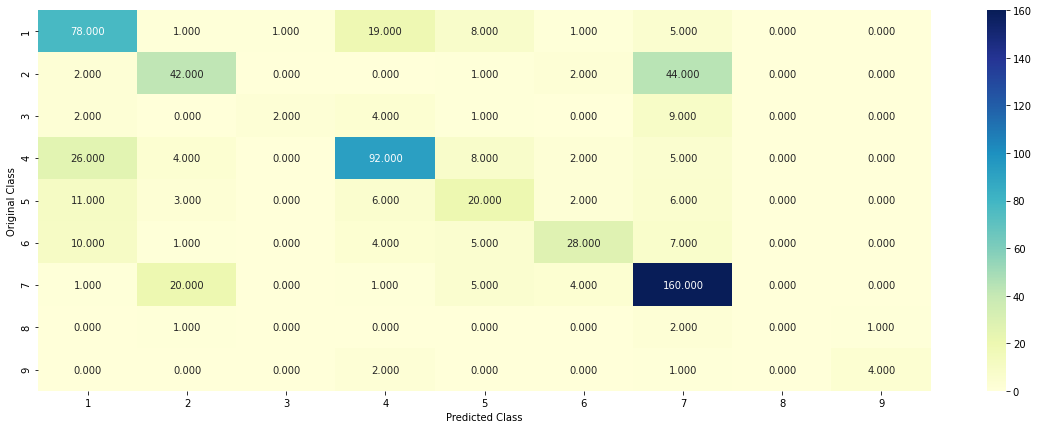

-------------------- Precision matrix (Columm Sum=1) --------------------


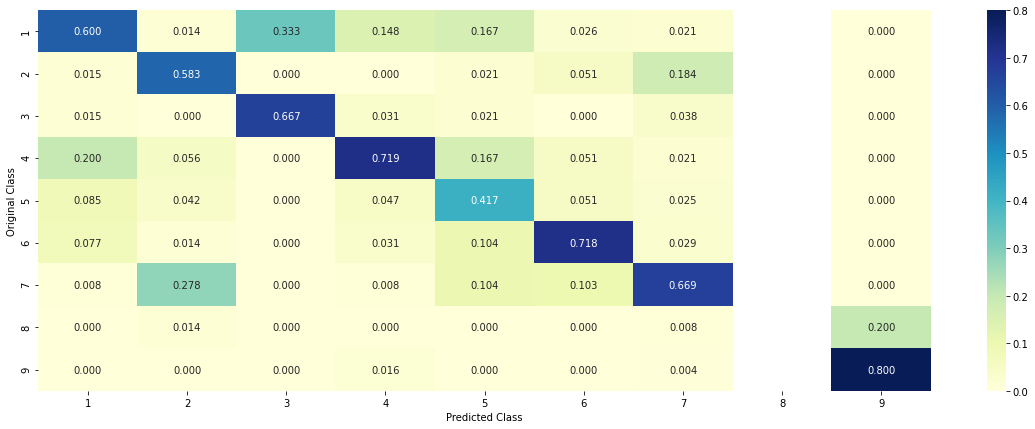

-------------------- Recall matrix (Row sum=1) --------------------


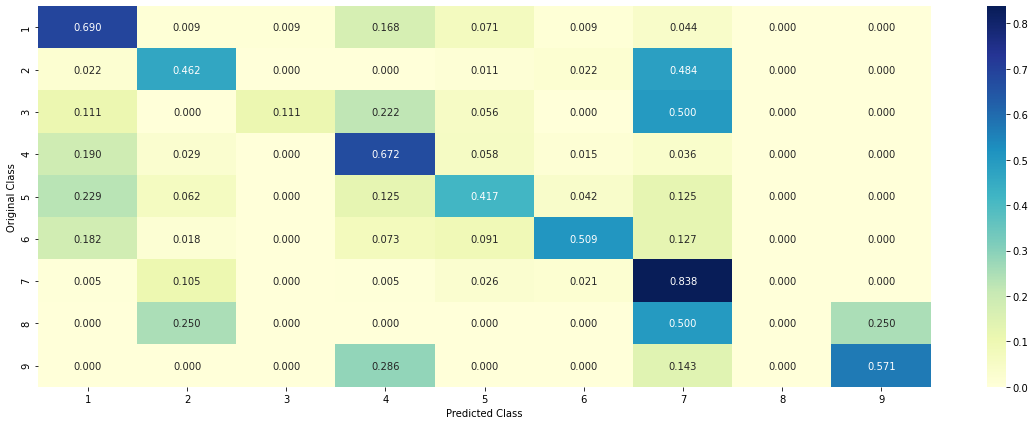

In [143]:
lr = LogisticRegression(C=0.1)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
sclf.fit(train_x_onehotCoding, y_train)

log_error = log_loss(y_train, sclf.predict_proba(train_x_onehotCoding))
print("Log loss (train) on the stacking classifier :",log_error)

log_error = log_loss(y_cv, sclf.predict_proba(cv_x_onehotCoding))
print("Log loss (CV) on the stacking classifier :",log_error)

log_error = log_loss(test_y, sclf.predict_proba(test_x_onehotCoding))
print("Log loss (test) on the stacking classifier :",log_error)

print("Number of missclassified point :", np.count_nonzero((sclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=sclf.predict(test_x_onehotCoding))

## Maximum Voting classifier

In [145]:
!pip install xgboost


In [146]:
from xgboost import XGBClassifier
import numpy as np
from sklearn.model_selection import RandomizedSearchCV

Hyper parameter tunning using One Hot Encoding

In [ ]:
n_estimators = [int(x) for x in np.linspace(start=10, stop=200, num=8)]
# learning Rate
learning_rate = [0.5, 0.1, 0.01, 0.001]
# maximum depth
max_depth = [3, 5, 10, 20]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
                       'max_depth': max_depth,
                       'learning_rate': learning_rate}
print(random_grid)
xgbt_randomcv = RandomizedSearchCV(estimator=XGBClassifier(), param_distributions=random_grid, n_iter=50, cv=3, verbose=3,
                                           random_state=100, n_jobs=-1)
### fit the randomized model for findind the best model parameter
xgbt_randomcv.fit(train_x_onehotCoding, y_train)
print(xgbt_randomcv.best_params_)
print("Best Model parameters are :",xgbt_randomcv.best_estimator_)


sig_clf = CalibratedClassifierCV(xgbt_randomcv.best_estimator_, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, y_train)
            
            

{'n_estimators': [10, 37, 64, 91, 118, 145, 172, 200], 'max_depth': [3, 5, 10, 20], 'learning_rate': [0.5, 0.1, 0.01, 0.001]}
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed: 130.9min


Testing model with best hyper parameters

In [ ]:
predict_and_plot_confusion_matrix(train_x_onehotCoding, y_train,test_x_onehotCoding,y_test,,xgbt_randomcv.best_estimator_)

Testing the Model with Random points

In [ ]:
test_point_index = 100
no_feature = 100
predicted_cls = sig_clf.predict(train_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(train_x_onehotCoding[test_point_index]),4))
print("Actuall Class :", y_test[test_point_index])
indices = np.argsort(-xgbt_randomcv.best_estimator_.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:no_feature], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

##Hyper parameter tunning for the Tfidf features

In [ ]:
n_estimators = [int(x) for x in np.linspace(start=10, stop=200, num=8)]
# learning Rate
learning_rate = [0.5, 0.1, 0.01, 0.001]
# maximum depth
max_depth = [3, 5, 10, 20]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
                       'max_depth': max_depth,
                       'learning_rate': learning_rate}
print(random_grid)
xgbt_randomcv = RandomizedSearchCV(estimator=XGBClassifier(), param_distributions=random_grid, n_iter=50, cv=3, verbose=3,
                                           random_state=100, n_jobs=-1)
### fit the randomized model for findind the best model parameter
xgbt_randomcv.fit(train_x_Tfidf, y_train)
print(xgbt_randomcv.best_params_)
print("Best Model parameters are :",xgbt_randomcv.best_estimator_)


sig_clf = CalibratedClassifierCV(xgbt_randomcv.best_estimator_, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, y_train)
            
            

Testing model with best hyper parameters

In [ ]:
predict_and_plot_confusion_matrix(train_x_Tfidf, y_train,test_x_Tfidf,y_test,,xgbt_randomcv.best_estimator_)

In [ ]:
test_point_index = 20
no_feature = 100
predicted_cls = sig_clf.predict(test_x_Tfidf[test_point_index].reshape(1,test_x_Tfidf.shape[1]))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_Tfidf[test_point_index].reshape(1,test_x_Tfidf.shape[1])),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-xgbt_randomcv.best_estimator_.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:no_feature], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)